Project - Ariel Hedvat and Yuval Rubinstein

In [69]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn import datasets, ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.impute import SimpleImputer
from typing import List, Dict
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, chi2_contingency
import warnings
from sklearn.ensemble import ExtraTreesClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

Loading the data:

In [70]:
### load the df

df = pd.read_csv("train.csv")
testing_df = pd.read_csv("test.csv")
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

In [71]:
print(df.shape)
df.head()

(60000, 24)


,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,numstrings,paths,urls,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C,label
0,a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...,6744064,6799360.0,524.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,64882.0,0.0,0.0,0.0,28.0,899075.0,13.857079,Win32 EXE PECompact compressed (generic),64.2,-3.978981,5.732354,er,1
1,ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...,22016,45056.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,89.0,0.0,0.0,0.0,1.0,856.0,9.617978,Win32 Dynamic Link Library (generic),38.4,7.064133,5.738201,er,0
2,b0b126adc73b980a114e38027b082d149fcf491547452f...,686136,704512.0,133.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,2699.0,0.0,32.0,0.0,2.0,32767.0,12.140422,Win64 Executable (generic),82.0,1.052727,5.722733,gow,0
3,ff6176c53ca9b58040c93870c264843b93b5e290c28e57...,8192,36864.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,71.0,0.0,0.0,0.0,1.0,678.0,9.549296,Win64 Executable (generic),28.0,2.217531,5.896053,vh,1
4,59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...,396288,421888.0,133.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,4729.0,0.0,0.0,0.0,5.0,35881.0,7.587439,Win64 Executable (generic),32.2,9.401164,NaN,vh,1


In [72]:
#calculating the number of missing values in each column of a DataFrame and creates a copy of the DataFrame with missing values filled in with 0

missing_values = df.isnull().sum()
print(missing_values)

main_df = df.copy()

sha256                    0
size                      0
vsize                  1935
imports                1739
exports                2093
has_debug              2927
has_relocations        3324
has_resources          1961
has_signature          1937
has_tls                2898
symbols                2656
numstrings             2718
paths                  3660
urls                   2349
registry               2525
MZ                     3089
printables             2739
avlength               2757
file_type_trid            0
file_type_prob_trid       0
A                      3704
B                      3751
C                      2051
label                     0
dtype: int64


Exploration: 

Our questions and thoughts on the data:

1. What are the correlations between features / label in our data
2. How do our features distribute and does the label affect them
3. How can we understand the features meaning / effects

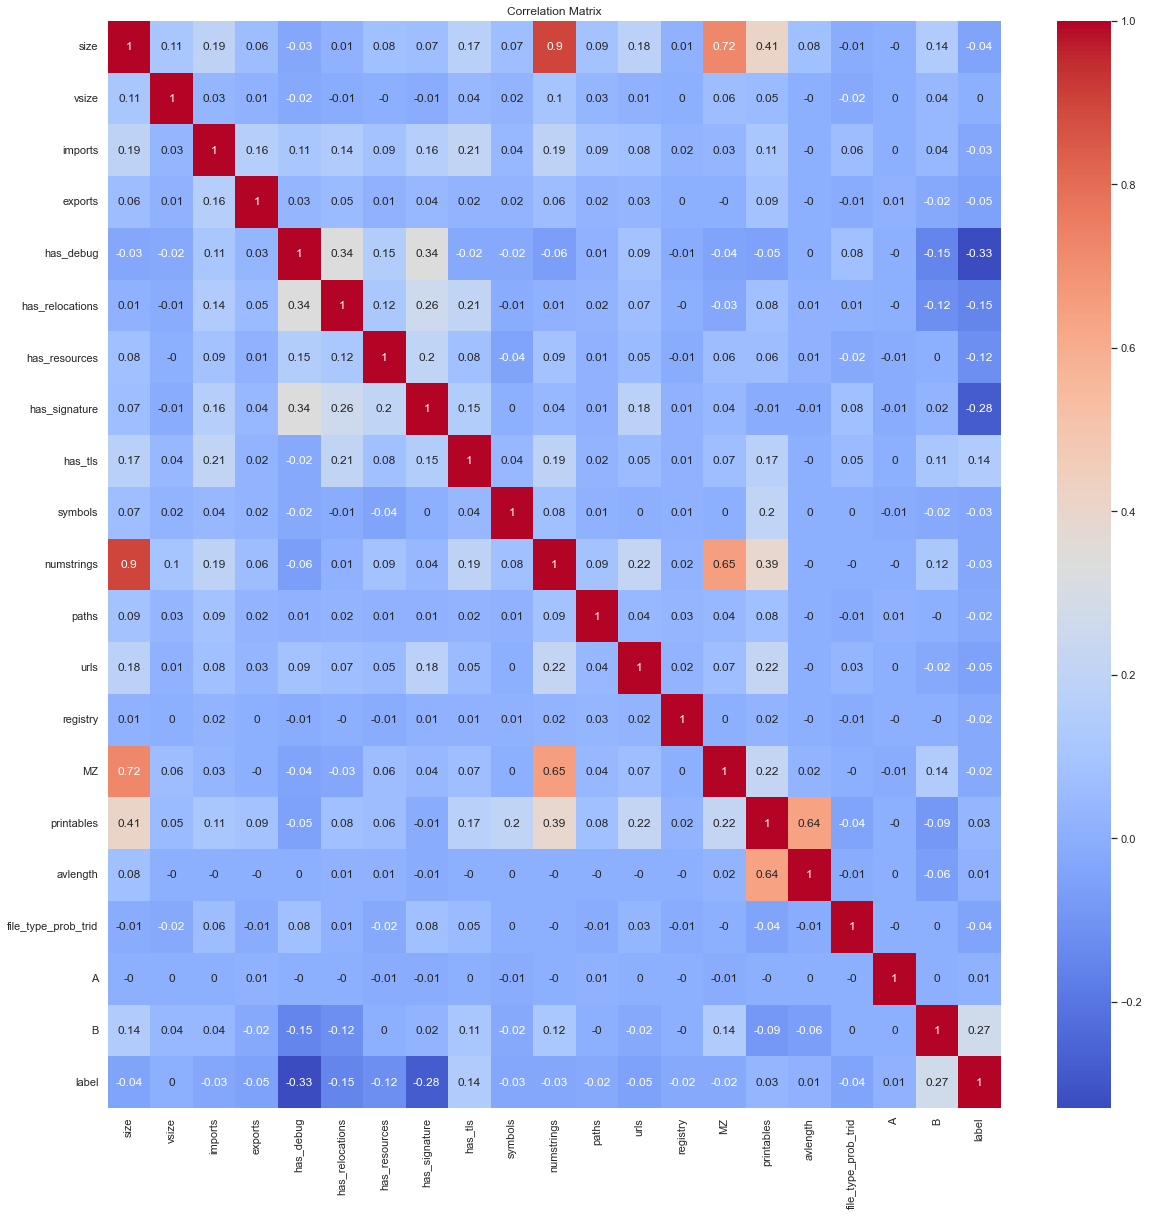

In [73]:
corr_matrix = main_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

Understanding the correlation table from first glance:

1. We can see unknown features such as 'A' and 'B' which we can't understand yet why they are correlated with other features since we don't know their business meaning.

2. We can see some correlations that we would expect such as size and printables but also we noticed one that we would like to understand such as "MZ" and 'Size' and their connection


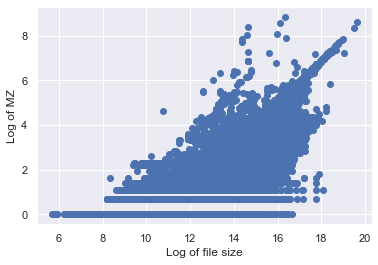

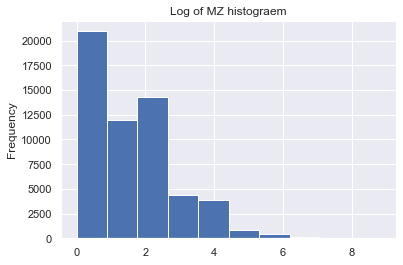

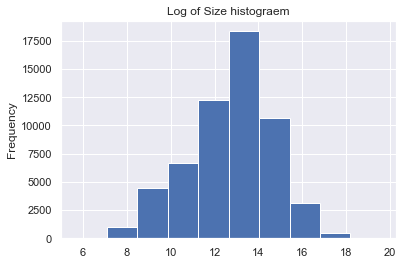

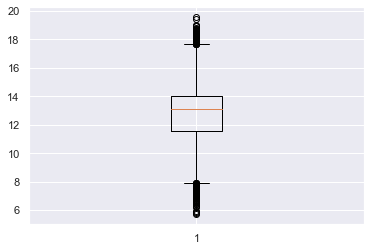

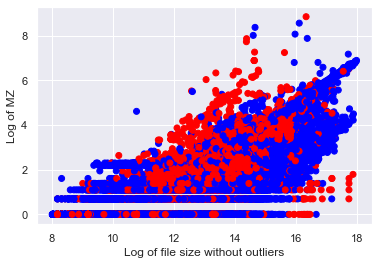

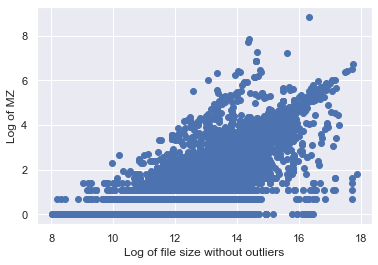

In [74]:
### understanding the MZ 

mz = main_df[main_df["MZ"] > 0]["MZ"]
size = main_df[main_df["MZ"] > 0]["size"]

logSize = np.log(size)
logMZ = np.log(mz)
plt.scatter(logSize, logMZ)
plt.xlabel("Log of file size")
plt.ylabel('Log of MZ')
plt.show()
plt.title("Log of MZ histograem")
logMZ.plot.hist()
plt.show()
plt.title("Log of Size histograem")
logSize.plot.hist()
plt.show()
plt.boxplot(logSize)
plt.show()

logSize_no_out = logSize[(logSize < 18) & (logSize > 8)]
MZ_no_out = main_df[(main_df["MZ"] > 0) & ((logSize < 18) & (logSize > 8))]["MZ"]
labels = main_df[(main_df["MZ"] > 0) & ((logSize < 18) & (logSize > 8))]['label']
label_colors = {1: 'red', 0: 'blue'}
plt.scatter(logSize_no_out, np.log(MZ_no_out), c=[label_colors[label] for label in labels])
plt.xlabel("Log of file size without outliers")
plt.ylabel('Log of MZ')
plt.show()
logSize_mal = logSize_no_out[(labels==1)]
mz_mal = MZ_no_out[(labels==1)]
plt.scatter(logSize_mal, np.log(mz_mal))
plt.xlabel("Log of file size without outliers")
plt.ylabel('Log of MZ')
plt.show()

Understanding MZ and Size:

While exploring the connection between size and MZ we noticed two things:

1. the connection between the log of each feature seem to correlate relatively in a linear way.
2. the data we explore is in very large numbers! what can it mean? it means that we might want to work not with the standard features themselves but with the log of base 10. The next steps will be transforming the data and understanding how transformations change the distributions of each feature.

There are 60000 observations


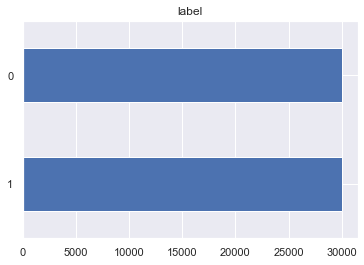

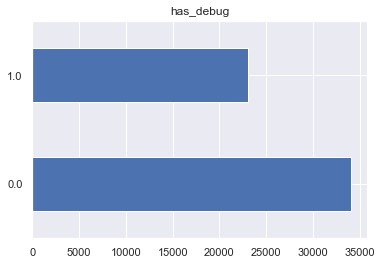

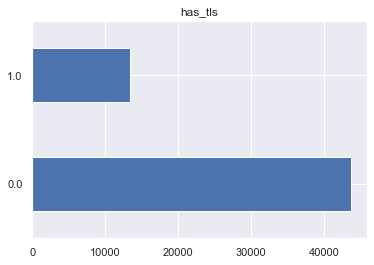

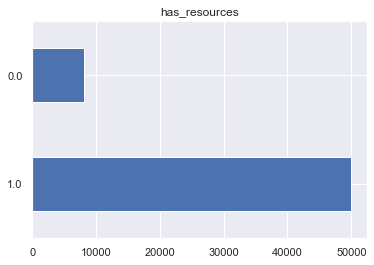

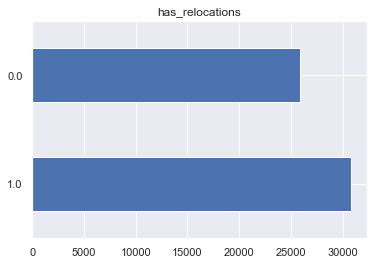

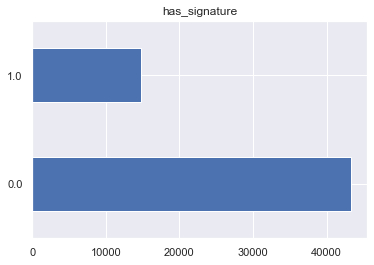

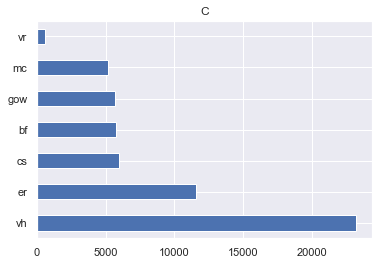

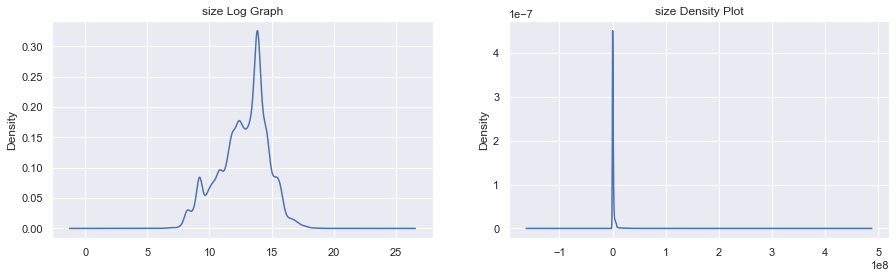

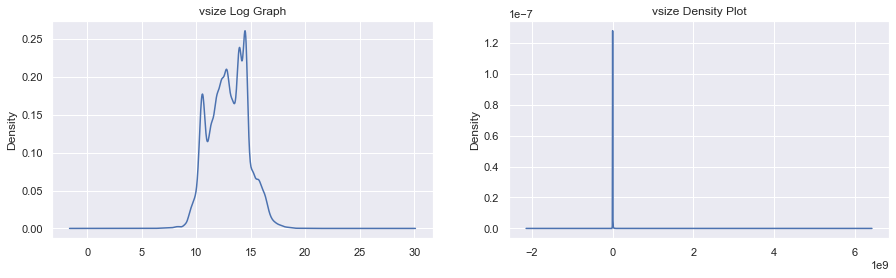

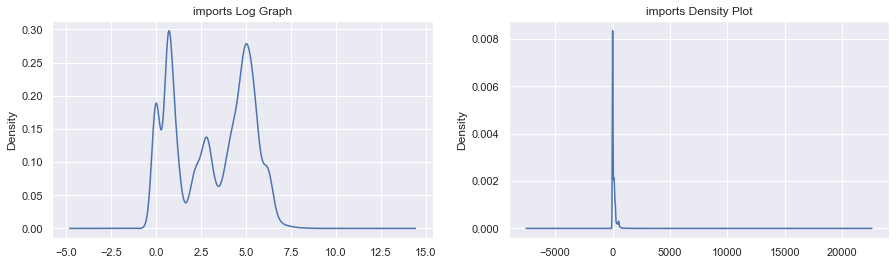

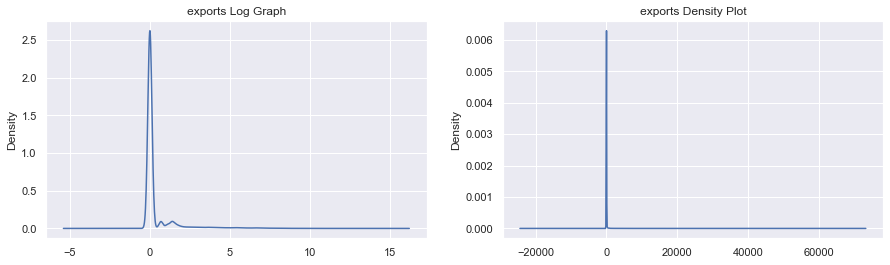

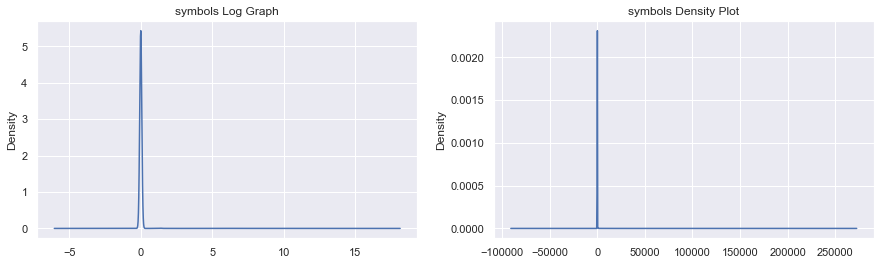

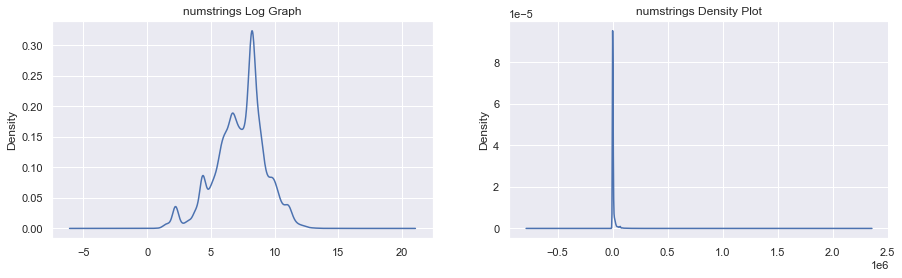

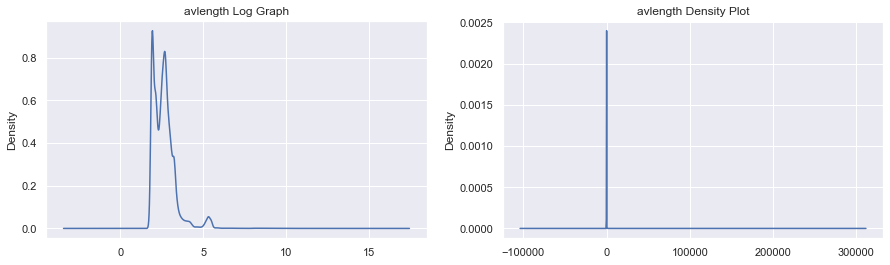

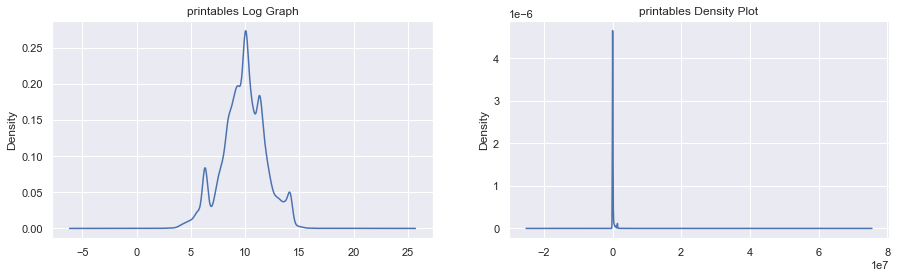

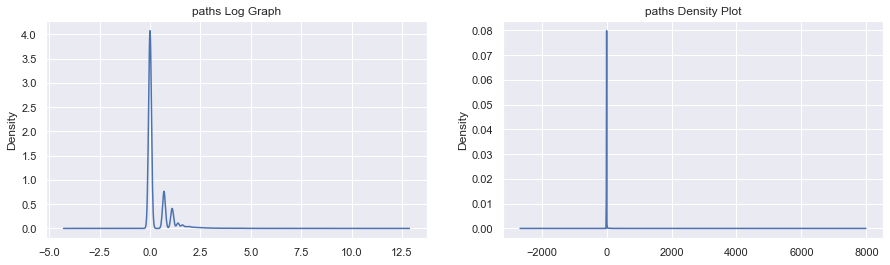

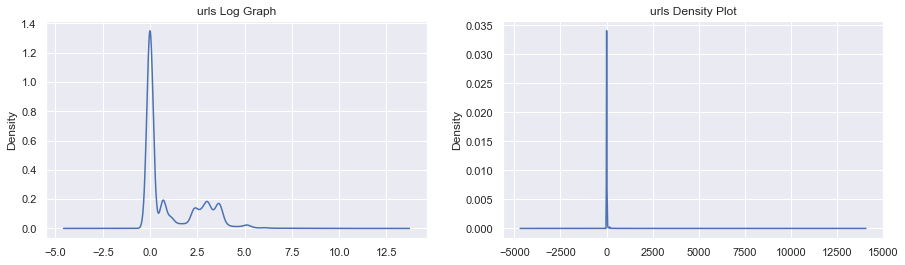

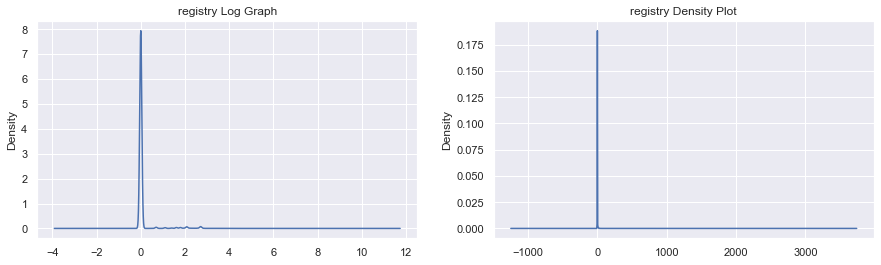

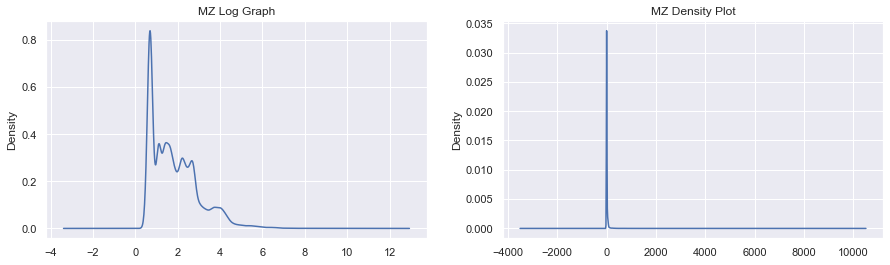

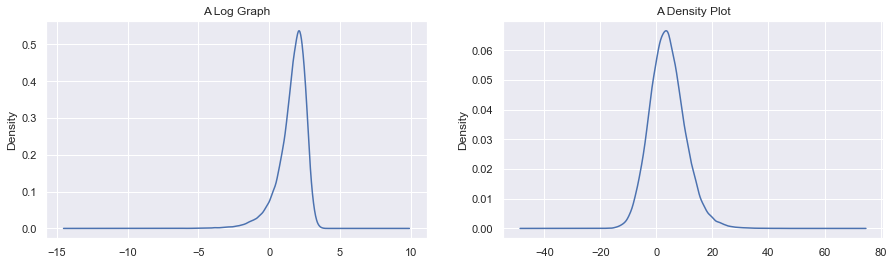

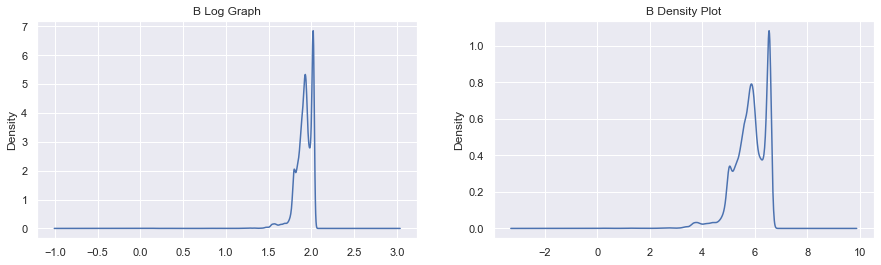

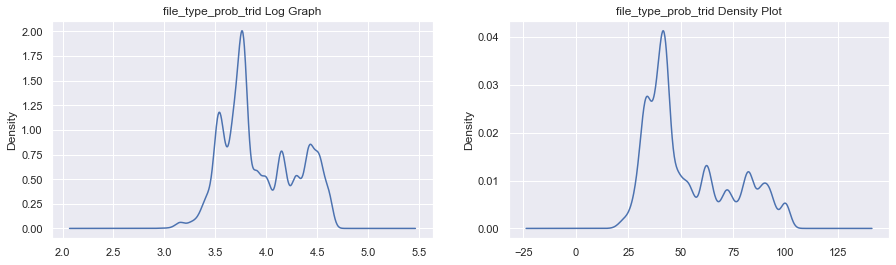

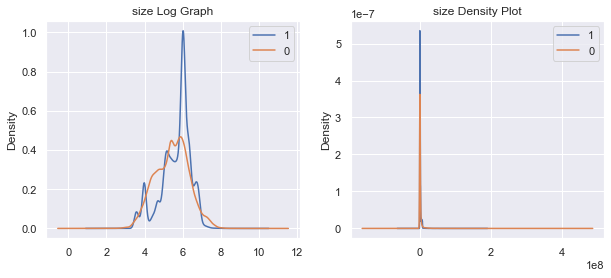

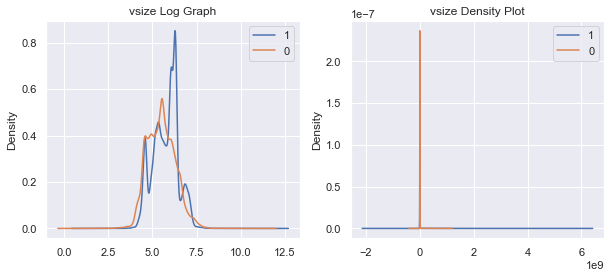

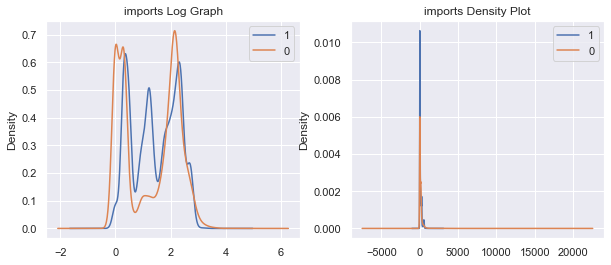

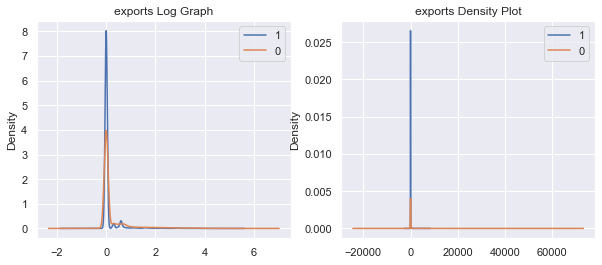

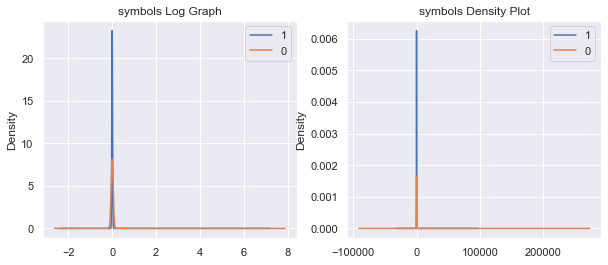

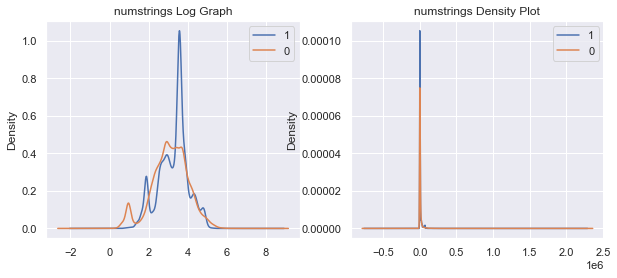

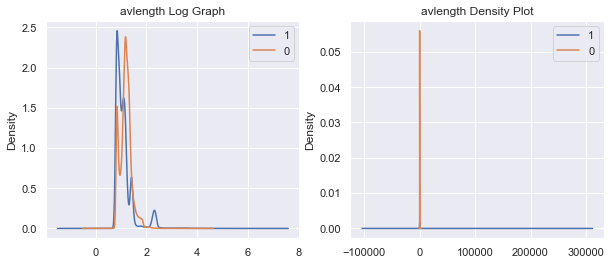

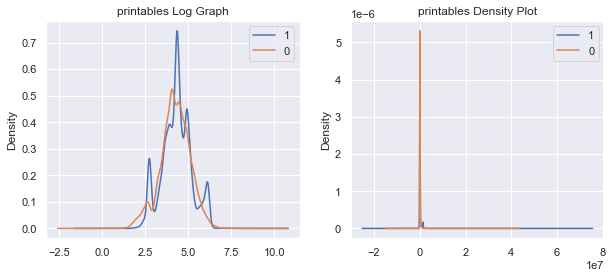

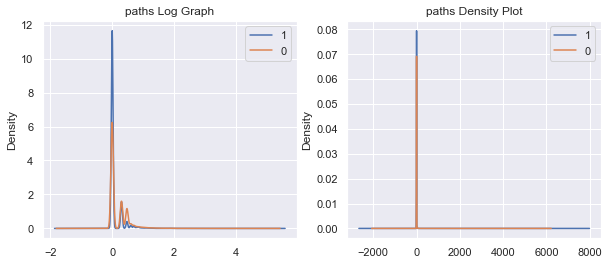

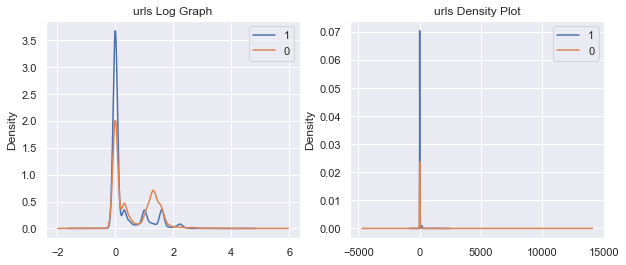

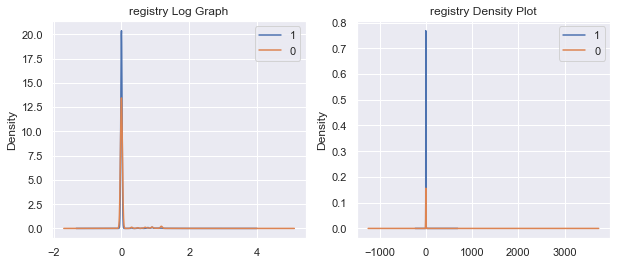

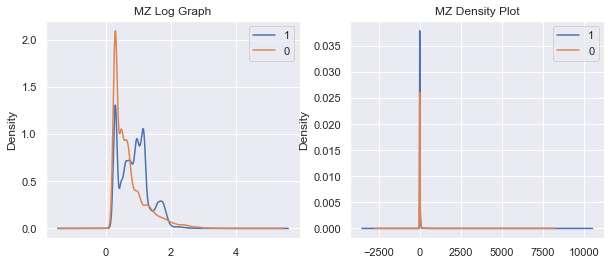

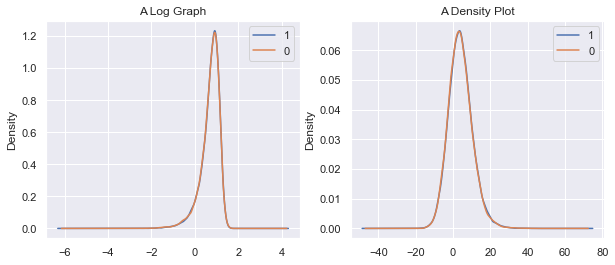

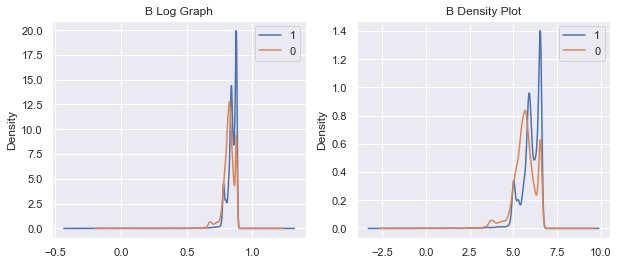

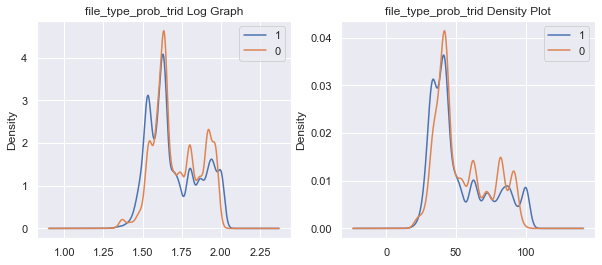

['vsize', 'Log of vsize', 'imports', 'Log of imports', 'exports', 'Log of exports', 'symbols', 'Log of symbols', 'numstrings', 'Log of numstrings', 'avlength', 'Log of avlength', 'printables', 'Log of printables', 'paths', 'Log of paths', 'urls', 'Log of urls', 'registry', 'Log of registry', 'MZ', 'Log of MZ', 'A', 'Log of A', 'B', 'Log of B']


'\nfeatures that look normally distributed:\nA\nlog of size\nlog of numstrings\nfeatures that log will increase the variance\nMZ\nurl\npaths\navlength\nsymbols, exports and imports\n\n\n'

In [75]:
### plotting all the features 

#some basic steps i think are important
num_features = df.shape[1]
num_observations = df.shape[0]
print(f"There are {num_observations} observations")

catagorial = ['label', 'has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature', 'C','file_type_trid']
numerical = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength', 'printables', 'paths', 'urls', 'registry', 'MZ', 'A', 'B', 'file_type_prob_trid']

norm_features = []
# Creating a boxplot for each numerical feature

ones = np.ones(main_df.shape[0])
for cat in catagorial:
    if ('type' in cat):
        continue
    main_df[cat].value_counts().plot.barh()
    plt.title(cat)
    plt.show()

# not by labels
for cat in numerical:

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    curr = np.log(ones + main_df[cat])
    curr.plot.density( ax=axes[0])

    
    main_df['Log of '+cat] = curr

    main_df[cat].plot.density(ax=axes[1])

    axes[0].set_title(cat + " Log Graph")
    axes[1].set_title(cat + " Density Plot")

    plt.show()

# by labels
for cat in numerical:

    fig, axes = plt.subplots(1, 2, figsize=(10 , 4))

    curr = np.log10(ones + main_df[cat])
    curr[main_df['label'] == 1].plot.density(ax=axes[0], label = '1')
    curr[main_df['label'] == 0].plot.density(ax=axes[0], label= '0')

    
    main_df['Log of '+cat] = curr

    main_df[main_df['label'] == 1][cat].plot.density(ax=axes[1], label= '1')
    main_df[main_df['label'] == 0][cat].plot.density(ax=axes[1], label= '0')

    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(cat + " Log Graph")
    axes[1].set_title(cat + " Density Plot")

    plt.show()
    test_statistic, p_value = stats.shapiro(main_df[cat])
    if (p_value > 0.05):
        norm_features = norm_features + [cat]
    test_statistic, p_value = stats.shapiro(curr)
    if (p_value > 0.05):
        norm_features = norm_features + ['Log of '+cat]


print(norm_features)
main_df.describe()  


'''
features that look normally distributed:
A
log of size
log of numstrings
features that log will increase the variance
MZ
url
paths
avlength
symbols, exports and imports


'''

What can we tell from our visualizations:

1. half of our data our malicious files and half are not. Which means have 30000 with label = 1 and 30000 with label = 0 (overall 60000 observations).
2. We have boolean features! such as has_debug, has_tls, has_resources, has_relocations, has_signiture with the values 0 or 1. Note: we can see most of of the files have resources.
3. we have 2 categorial features, file_type_trid and and C (we don't now what C is but lets see if it helps at all)
NOTE: we can see that "C" doesn't have much values, we could use it as a dummy variable, however, for file_type_trid (which will be plotted later), that has many values, we can't, we will see later how can use it.

4. we can see many continuous featuress distributions are easier to understand by adding the log, some distribute normally after adding the log, some are normally distributed such as size, numstrings and printables. the other features are affected by having greater variance after adding the log.
NOTE: this excludes features such as A and B that don't need the log, A already is normally distributed and B's variance is not affected by the log.

5. In addition to the understanding of the distributions, we visualize differences between malicious and non malicious files via the density plot. for certain features such as MZ and B are affected by the label (with opposite effects, one shifts to the right and the other to the left in the distribution according only to the visualizations)


* Now we will be using the log of the continious features (where it helps) in order to see further connections

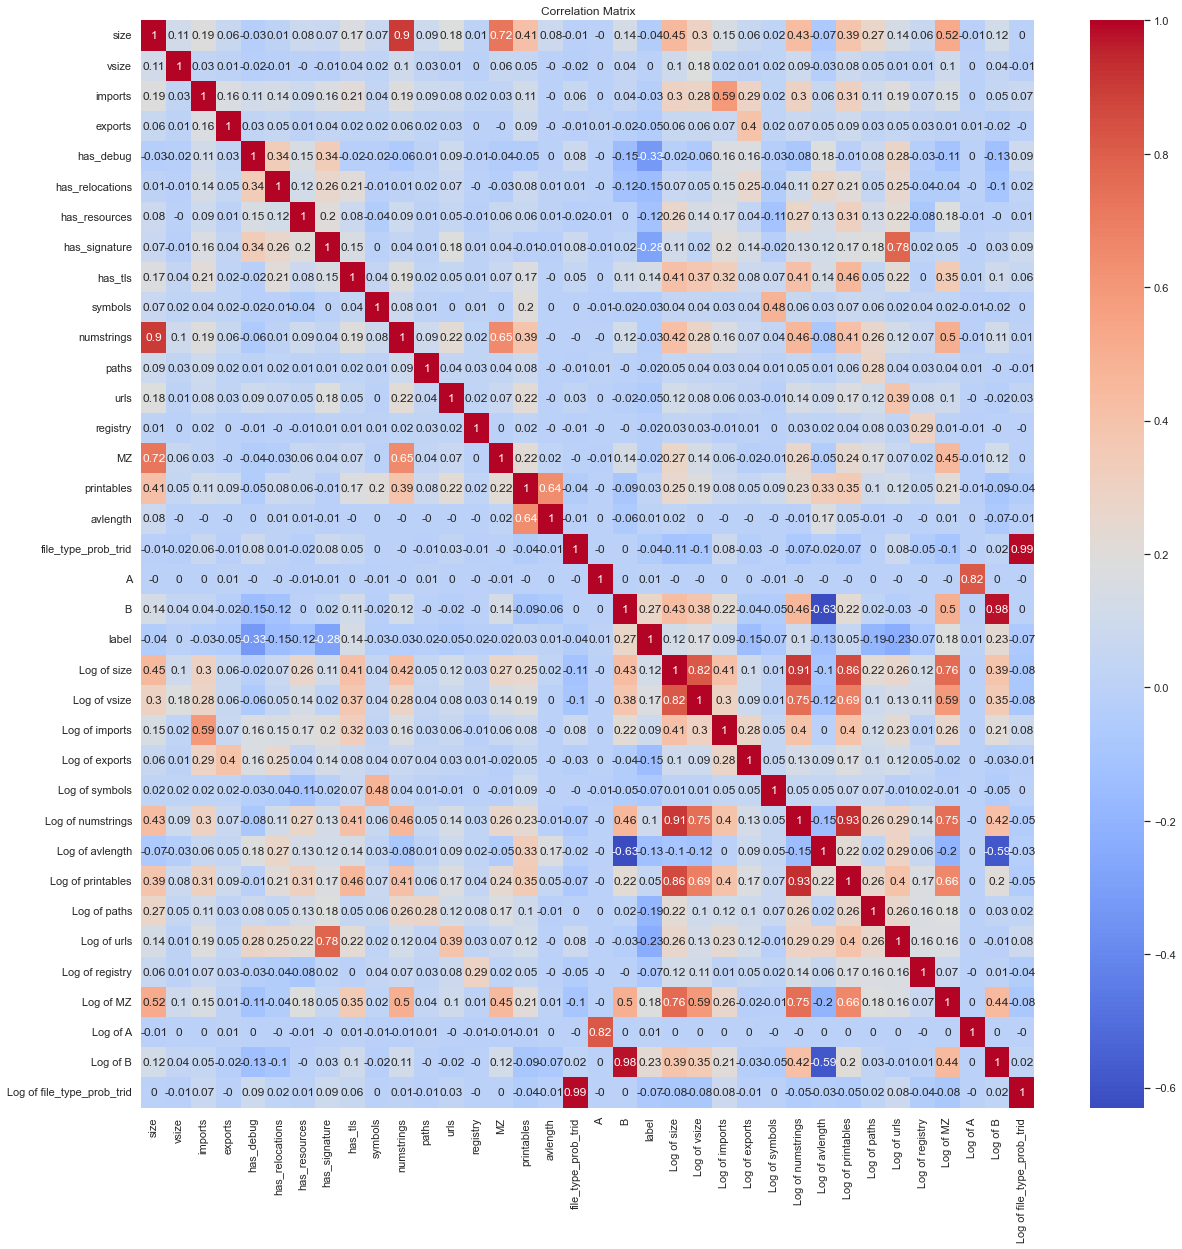

In [76]:
normal_log = ['size', 'numstrings']
to_log = ['size', 'vsize','numstrings','printables', 'MZ', 'urls', 'paths', 'avlength' ,'symbols', 'exports', 'imports', 'registry']
corr_matrix = main_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

Above we see the correlation matrix with ALL of the features (including their log features). we see certain connections that don't surprise us at all, (feature and its log) however we see new correlations overall, seeing the bottom right corner of the correlation matrix, we see more correlations not between 2 features but their log values.

Understanding some of the features we thought might be interesting:

We will do some visualizaitons and conclunsions on the training data regarding some features.


Understanding the symbols and the effect of the label

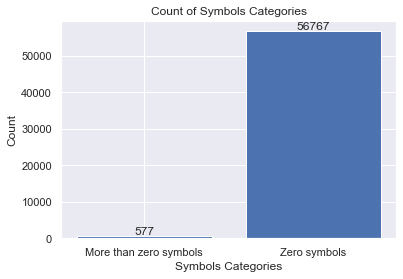

In [77]:
more_than_zero_symbols = len(main_df[main_df['symbols'] > 0])
zero_symbols = len(main_df[main_df['symbols'] == 0])

symbols_categories = ['More than zero symbols', 'Zero symbols']
symbols_counts = [more_than_zero_symbols, zero_symbols]

plt.bar(symbols_categories, symbols_counts)
plt.xlabel('Symbols Categories')
plt.ylabel('Count')
plt.title('Count of Symbols Categories')

# Add numbers on top of each bar
for i, count in enumerate(symbols_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

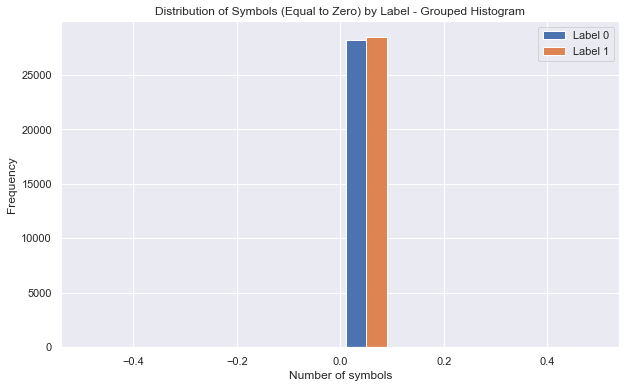

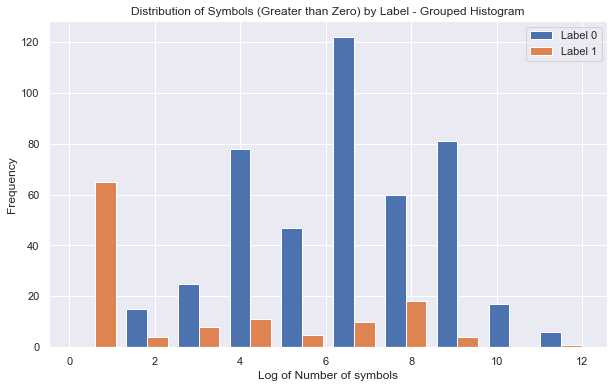

In [78]:

zero_symbols_label_0 = main_df[(main_df['symbols'] == 0) & (main_df['label'] == 0)]['symbols']
zero_symbols_label_1 = main_df[(main_df['symbols'] == 0) & (main_df['label'] == 1)]['symbols']
plt.figure(figsize=(10, 6))
# Grouped Histogram
plt.hist([zero_symbols_label_0, zero_symbols_label_1], bins=10, label=['Label 0', 'Label 1'])
plt.xlabel('Number of symbols')
plt.ylabel('Frequency')
plt.title('Distribution of Symbols (Equal to Zero) by Label - Grouped Histogram')
plt.legend()
plt.show()

bigger_zero_symbols_label_0 = main_df[(main_df['symbols'] > 0) & (main_df['label'] == 0)]['symbols']
bigger_zero_symbols_label_1 = main_df[(main_df['symbols'] > 0) & (main_df['label'] == 1)]['symbols']
plt.figure(figsize=(10, 6))
bigger_zero_symbols_label_0_log = np.log(bigger_zero_symbols_label_0)
bigger_zero_symbols_label_1_log = np.log(bigger_zero_symbols_label_1)
# Grouped Histogram
plt.hist([bigger_zero_symbols_label_0_log, bigger_zero_symbols_label_1_log], bins=10, label=['Label 0', 'Label 1'])
plt.xlabel('Log of Number of symbols')
plt.ylabel('Frequency')
plt.title('Distribution of Symbols (Greater than Zero) by Label - Grouped Histogram')
plt.legend()
plt.show()



Conclusions:
The vast majority of our data, has 0 symbols in the file, and barely has any effect on the labels of our data because we see it's half and half. (according the bar plot). We do see once we go to files with more than 0 symbols a certain dependency of the label, however the change is extremly negligable.

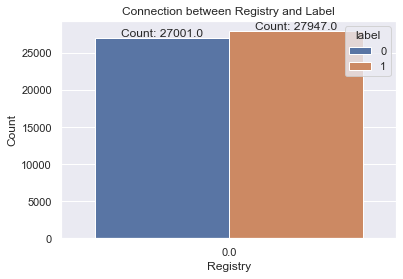

Number of Labels that are 1 with registry 0: 27947
Number of Labels that are 0 with registry 0: 27001


In [79]:
df_registry_0 = main_df[main_df['registry']==0]

# Create a count plot
ax = sns.countplot(data=df_registry_0, x='registry', hue='label')

# Get the counts
label_1_registry_0 = len(df_registry_0[df_registry_0['label'] == 1])
label_0_registry_0 = len(df_registry_0[df_registry_0['label'] == 0])

# Annotate the bars with count values
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f"Count: {p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')

# Set labels and title
plt.xlabel('Registry')
plt.ylabel('Count')
plt.title('Connection between Registry and Label')

# Display the plot
plt.show()

# Print the counts
print(f"Number of Labels that are 1 with registry 0: {label_1_registry_0}")
print(f"Number of Labels that are 0 with registry 0: {label_0_registry_0}")

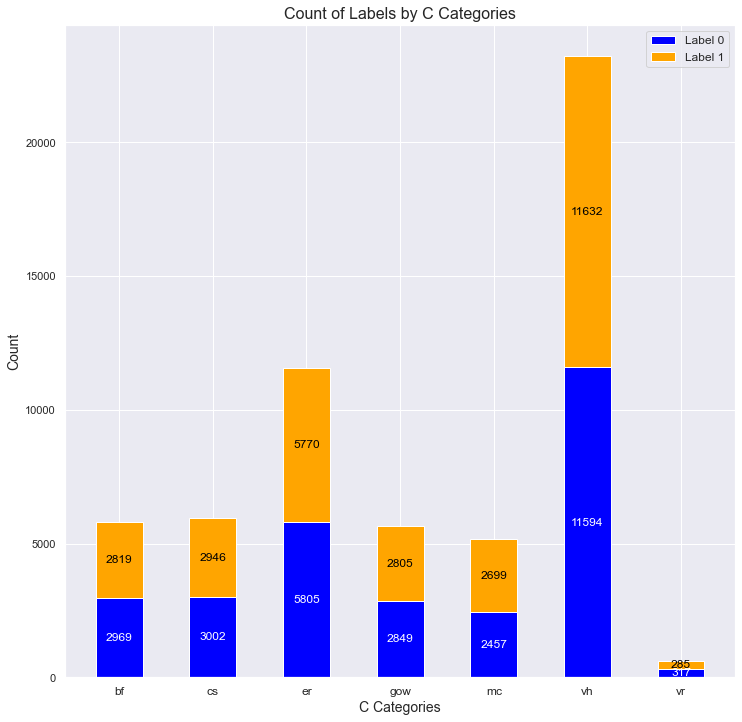

In [80]:
#comparing the distribution of safe and malicious files across different categories ('C'). 
grouped_data = main_df.groupby(['C', 'label']).size().unstack()
plt.figure(figsize=(12, 12))
colors = ['blue', 'orange']
num_categories = len(grouped_data)
bar_width = 0.5
bar_positions = np.arange(num_categories)
plt.bar(bar_positions, grouped_data[0], color=colors[0], width=bar_width, label='Label 0')
plt.bar(bar_positions, grouped_data[1], color=colors[1], width=bar_width, bottom=grouped_data[0], label='Label 1')
plt.xticks(bar_positions, grouped_data.index)
plt.xticks(bar_positions, grouped_data.index, fontsize=12)
plt.xlabel('C Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Labels by C Categories', fontsize=16)
plt.legend(fontsize=12)

# Increase the gap between count numbers
label_0_offset = 0.15
label_1_offset = 0.3

# Add numbers for label 0
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] / 2, f'{grouped_data.iloc[i, 0]}', ha='center', va='center', color='white')

# Add numbers for label 1
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] + grouped_data.iloc[i, 1] / 2, f'{grouped_data.iloc[i, 1]}', ha='center', va='center', color='black')

plt.show()

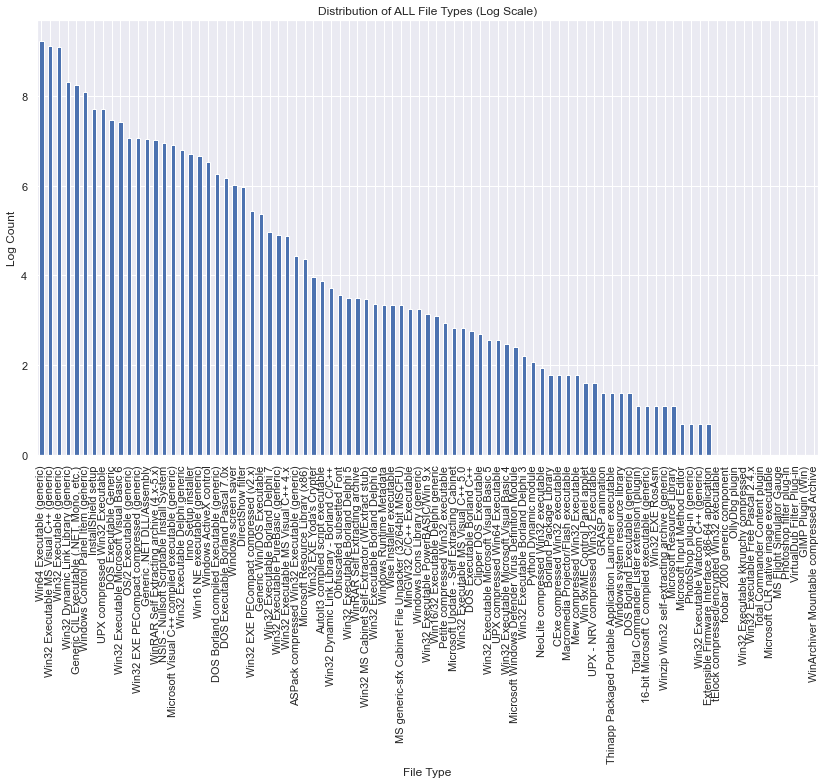

In [81]:
file_type_counts = main_df['file_type_trid'].value_counts()
log_counts = np.log(file_type_counts)

# Plot the bar chart with log-transformed counts
plt.figure(figsize=(14, 8))
log_counts.plot(kind='bar')
plt.xlabel('File Type')
plt.ylabel('Log Count')
plt.title('Distribution of ALL File Types (Log Scale)')
plt.xticks(rotation=90)
plt.show()

Win32 EXE 


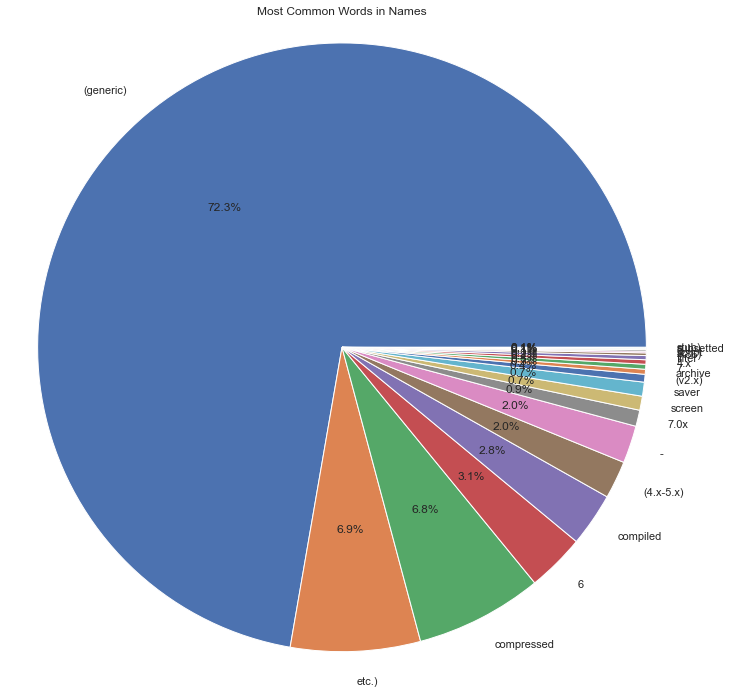

In [82]:
all_names = ' '.join(main_df['file_type_trid'].astype(str))
print(all_names[:10])
# Split the string into individual words
words = all_names.split()

# Create a dictionary to store word frequencies
word_counts = {}
excluded_words = ["win", "exe"]
# Count the frequency of each word
for word in words:
    #check if redundant
    if any(ex in word.lower() for ex in excluded_words):
        continue

    if word in word_counts:
        word_counts[word.lower()] += 1
    else:
        word_counts[word.lower()] = 1
   

# Sort the word frequencies in descending order
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Get the most common words and their counts
most_common_words = sorted_counts[:20]  # Adjust the number (5 in this case) as desired

# Extract the labels and counts from the most common words
labels = [word[0] for word in most_common_words]
counts = [word[1] for word in most_common_words]

# Plot the pie chart
plt.figure(figsize=(12, 12))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Most Common Words in Names')
plt.axis('equal')
plt.show()

In [83]:

#we can make new features of: is_exe, is_generic and is_win32
cat_df = df.copy()
c_test = testing_df.copy()
# Create new features
top_words = ['generic', 'compressed', 'etc']
#we want for every word in the top 10 to be 0 if the word includes it or 1 if doesnt

for word in top_words:
    col_name = 'is_'+word
    cat_df[col_name] = np.zeros(cat_df.shape[0])
    c_test[col_name] = np.zeros(c_test.shape[0])
    cat_df.loc[cat_df['file_type_trid'].str.lower().str.contains(word), col_name] = 1
    c_test.loc[c_test['file_type_trid'].str.lower().str.contains(word), col_name] = 1


In [84]:
#we can make new features of: is_exe, is_generic and is_win32
cat_df = df.copy()
c_test = testing_df.copy()
# Create new features
top_words = ['generic', 'etc','compressed']
#we want for every word in the top 10 to be 0 if the word includes it or 1 if doesnt

for word in top_words:
    col_name = 'is_'+word
    cat_df[col_name] = np.zeros(cat_df.shape[0])
    c_test[col_name] = np.zeros(c_test.shape[0])
    cat_df.loc[cat_df['file_type_trid'].str.lower().str.contains(word), col_name] = 1
    c_test.loc[c_test['file_type_trid'].str.lower().str.contains(word), col_name] = 1

col_name = "is_C++"
cat_df[col_name] = np.zeros(cat_df.shape[0])
c_test[col_name] = np.zeros(c_test.shape[0])
cat_df.loc[cat_df['file_type_trid'].str.contains('C+'), col_name] = 1
c_test.loc[c_test['file_type_trid'].str.contains('C+'), col_name] = 1

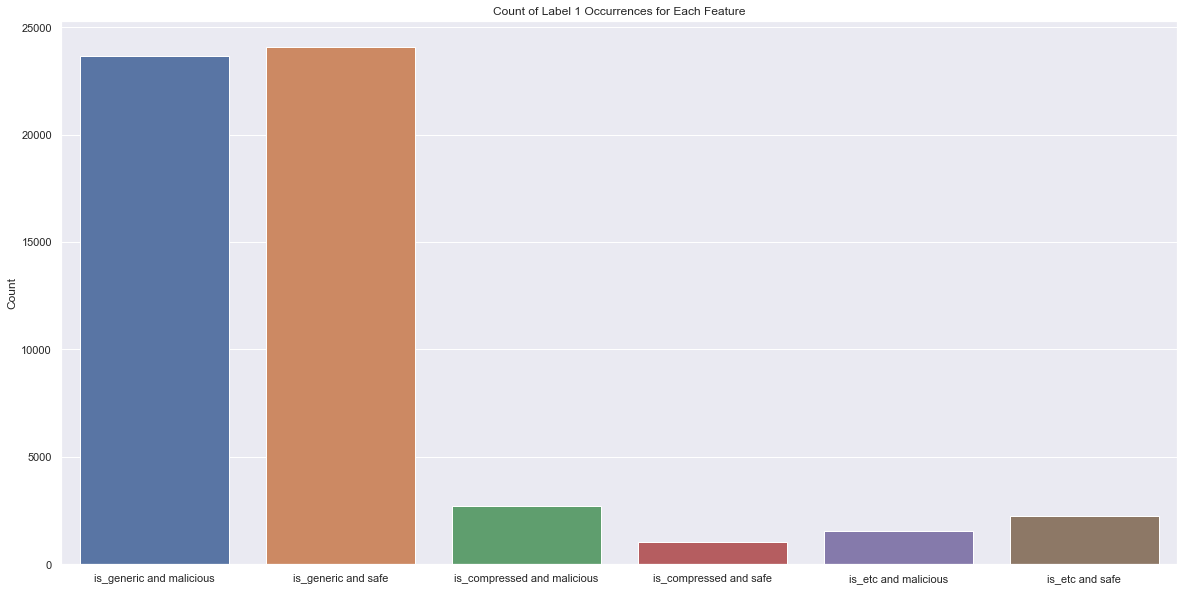

In [85]:

counts = [
    len(cat_df[(cat_df['is_generic'] == 1) & (cat_df['label'] == 1)]),
    len(cat_df[(cat_df['is_generic'] == 1) & (cat_df['label'] == 0)]),
    len(cat_df[(cat_df['is_compressed'] == 1) & (cat_df['label'] == 1)]),
    len(cat_df[(cat_df['is_compressed'] == 1) & (cat_df['label'] == 0)]),
    len(cat_df[(cat_df['is_etc'] == 1) & (cat_df['label'] == 1)]),
    len(cat_df[(cat_df['is_etc'] == 1) & (cat_df['label'] == 0)])
]

# Create a bar plot
plt.figure(figsize=(20,10))
sns.barplot(x=['is_generic and malicious','is_generic and safe', 'is_compressed and malicious', 'is_compressed and safe', 'is_etc and malicious', 'is_etc and safe'], y=counts)
plt.title('Count of Label 1 Occurrences for Each Feature')

plt.ylabel('Count')
plt.show()

In [86]:
### Chi Sq test to check contingency between the words and labels

for feature in ['is_generic', 'is_compressed', 'is_etc']:
    contingency_table = pd.crosstab(cat_df[feature], cat_df['label'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f"Feature: {feature}")
    print(f"Contingency Table:\n{contingency_table}\n")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value:{p_value:.10f}")
    print("")

## P-value is very small
### CHECK LATER TO MAKE IT  EVEN BETTER

Feature: is_generic
Contingency Table:
label           0      1
is_generic              
0.0          5906   6330
1.0         24094  23670

Chi-square statistic: 18.3692670175601
P-value:0.0000181970

Feature: is_compressed
Contingency Table:
label              0      1
is_compressed              
0.0            28960  27306
1.0             1040   2694

Chi-square statistic: 780.3269423181962
P-value:0.0000000000

Feature: is_etc
Contingency Table:
label       0      1
is_etc              
0.0     27742  28454
1.0      2258   1546

Chi-square statistic: 141.88763168477698
P-value:0.0000000000



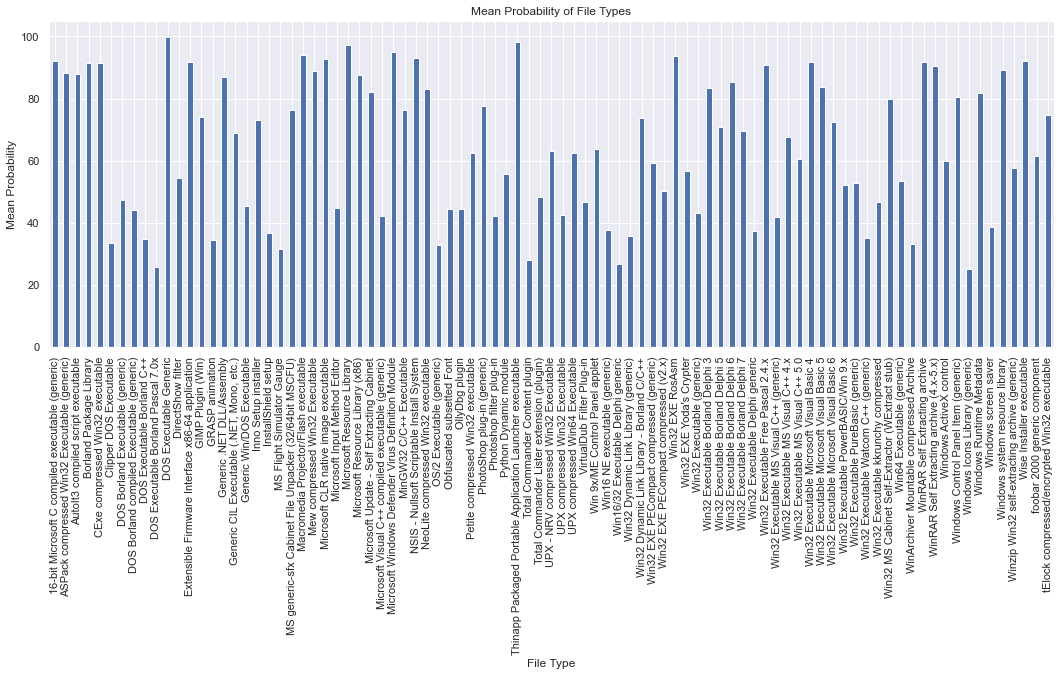

In [87]:
#In this code, we group the data by "file_type_trid" and calculate the mean probability ("file_type_prob_trid") for each file type. 
# Then, we create a bar plot where each bar represents a file type, 
# and the height of each bar corresponds to the mean probability of that file type.

# Group the data by file_type_trid and calculate the mean probability for each file type
file_type_prob_means = main_df.groupby('file_type_trid')['file_type_prob_trid'].mean()

# Plot the bar chart
plt.figure(figsize=(18, 6))
file_type_prob_means.plot(kind='bar')
plt.xlabel('File Type')
plt.ylabel('Mean Probability')
plt.title('Mean Probability of File Types')
plt.xticks(rotation=90)
plt.show()

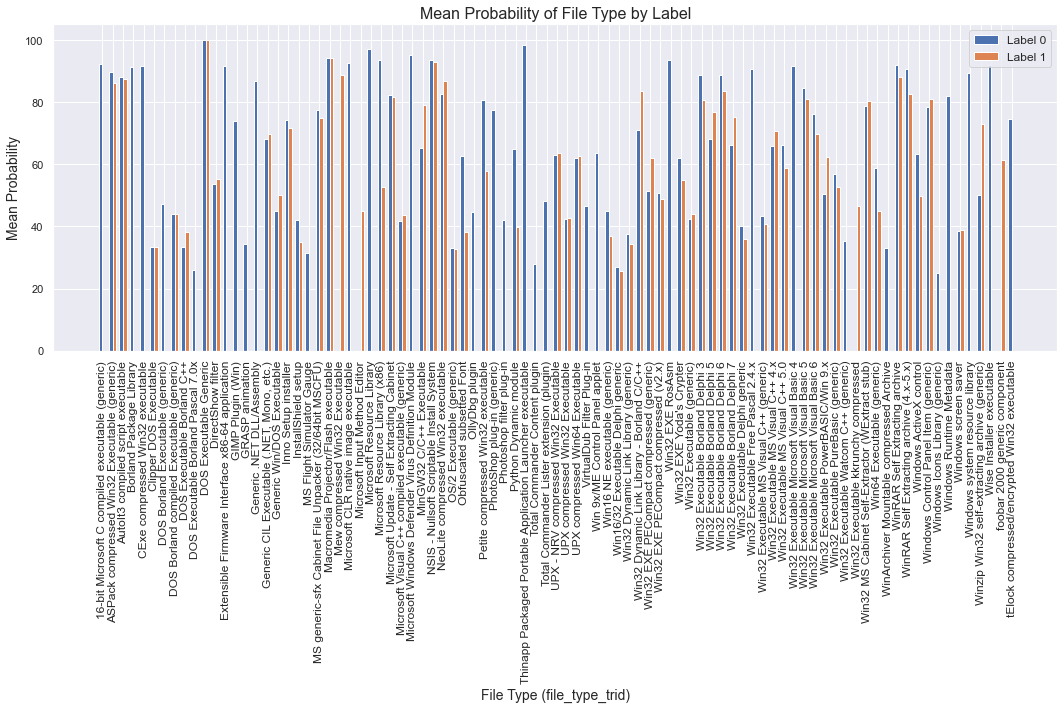

In [88]:
# Group the data by file_type_trid and label, and calculate the mean probabilities
grouped_data = main_df.groupby(['file_type_trid', 'label'])['file_type_prob_trid'].mean().unstack()

# Plotting the grouped bar chart
plt.figure(figsize=(18, 6))
bar_width = 0.35
bar_positions = np.arange(len(grouped_data))

# Plot bars for label 0
plt.bar(bar_positions - bar_width/2, grouped_data[0], width=bar_width, label='Label 0')

# Plot bars for label 1
plt.bar(bar_positions + bar_width/2, grouped_data[1], width=bar_width, label='Label 1')

plt.xlabel('File Type (file_type_trid)', fontsize=14)
plt.ylabel('Mean Probability', fontsize=14)
plt.title('Mean Probability of File Type by Label', fontsize=16)
plt.xticks(bar_positions, grouped_data.index, rotation=90, fontsize=12)
plt.legend(fontsize=12)

plt.show()

#when the mean probabiliy is high there are more label 0 (safe files)

Top 5 Files with the Highest Label 1 Percentages:
file_type_trid
Mew compressed Win32 Executable                   100.00000
Microsoft Input Method Editor                     100.00000
Win32 Executable kkrunchy compressed              100.00000
foobar 2000 generic component                     100.00000
Winzip Win32 self-extracting archive (generic)     59.24421
dtype: float64

Average Probabilities for the Top 5 Files:
file_type_trid
Mew compressed Win32 Executable                   88.8
Microsoft Input Method Editor                     44.9
Win32 Executable kkrunchy compressed              46.7
foobar 2000 generic component                     61.5
Winzip Win32 self-extracting archive (generic)    72.9
Name: 1, dtype: float64


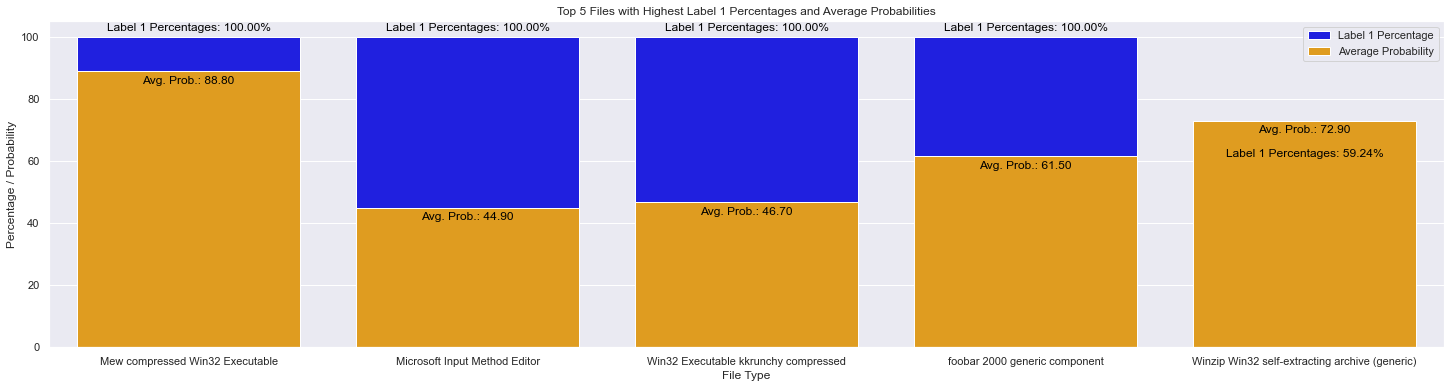

In [89]:
# Group the data by file_type_trid and label, and calculate the mean probabilities
grouped_data = main_df.groupby(['file_type_trid', 'label'])['file_type_prob_trid'].mean().unstack().fillna(0)

# Calculate the percentage of label 1 for each file type
total_counts = grouped_data.sum(axis=1)
label1_percent = grouped_data[1] / total_counts * 100

# Find the top 5 files with the highest label 1 percentages
top_label1_files = label1_percent.nlargest(5)
print("Top 5 Files with the Highest Label 1 Percentages:")
print(top_label1_files)
print()

# Calculate the average probabilities for the top 5 files
average_probabilities = grouped_data.loc[top_label1_files.index, 1]
print("Average Probabilities for the Top 5 Files:")
print(average_probabilities)

# Plot the label 1 percentages and average probabilities for the top 5 files
plt.figure(figsize=(25, 6))
sns.barplot(x=top_label1_files.index, y=top_label1_files.values, color='blue', label='Label 1 Percentage')
sns.barplot(x=top_label1_files.index, y=average_probabilities, color='orange', label='Average Probability')
plt.xlabel('File Type')
plt.ylabel('Percentage / Probability')
plt.title('Top 5 Files with Highest Label 1 Percentages and Average Probabilities')
for i, percentage in enumerate(top_label1_files):
    avg_probability = average_probabilities.iloc[i]
    plt.text(i, percentage + 2, f'Label 1 Percentages: {percentage:.2f}%', ha='center', color='black')
    plt.text(i, avg_probability - 4, f'Avg. Prob.: {avg_probability:.2f}', ha='center', color='black')

plt.legend()
plt.show()

Steps for pre processing

1. removing features by correlations

2. removing outliers

3. dealing with missing values

4. normilization

In [90]:
train_df = cat_df.copy()

['er' 'gow' 'vh' 'cs' 'bf' 'mc' 'vr' nan]


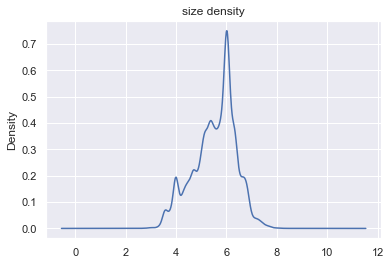

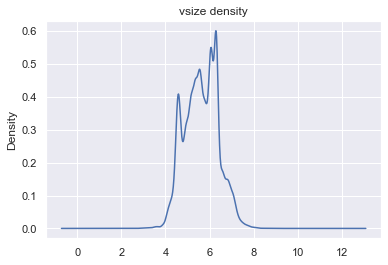

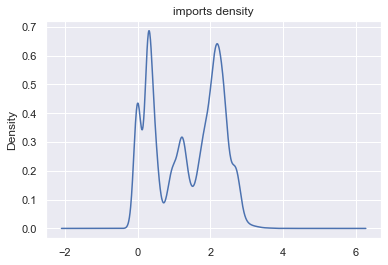

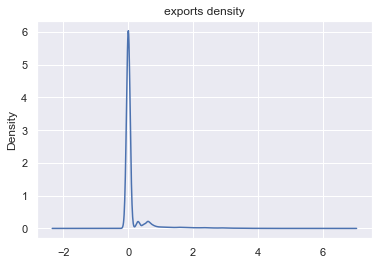

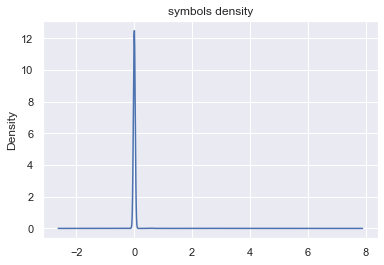

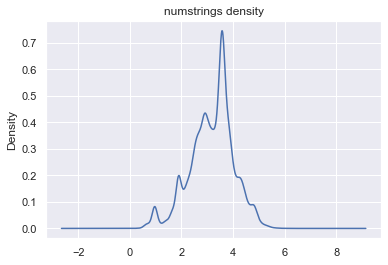

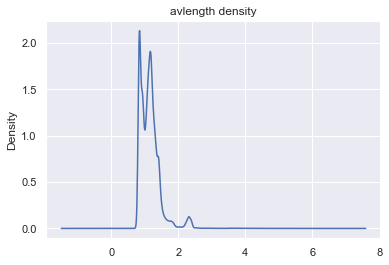

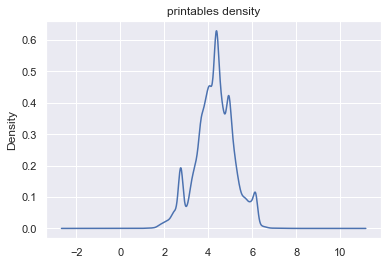

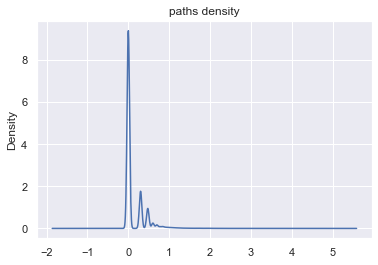

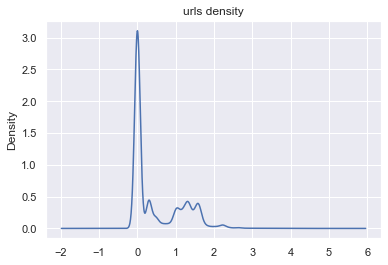

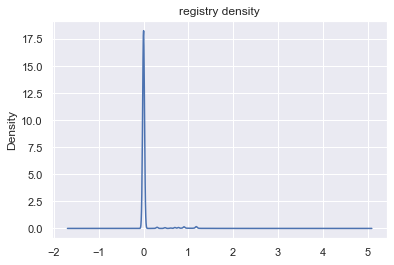

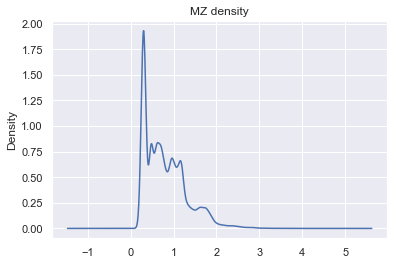

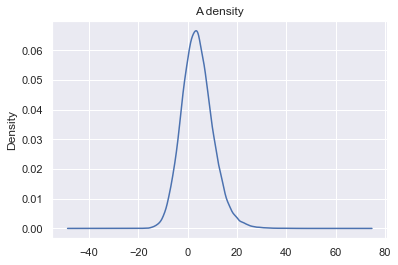

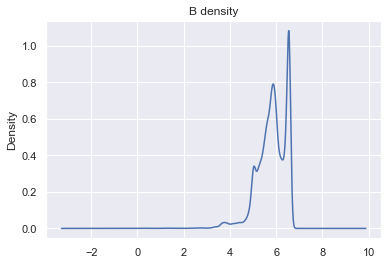

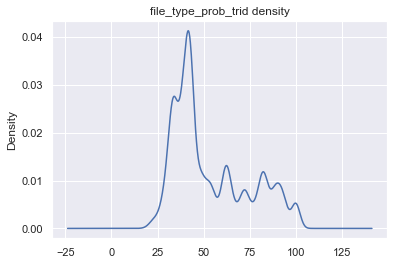

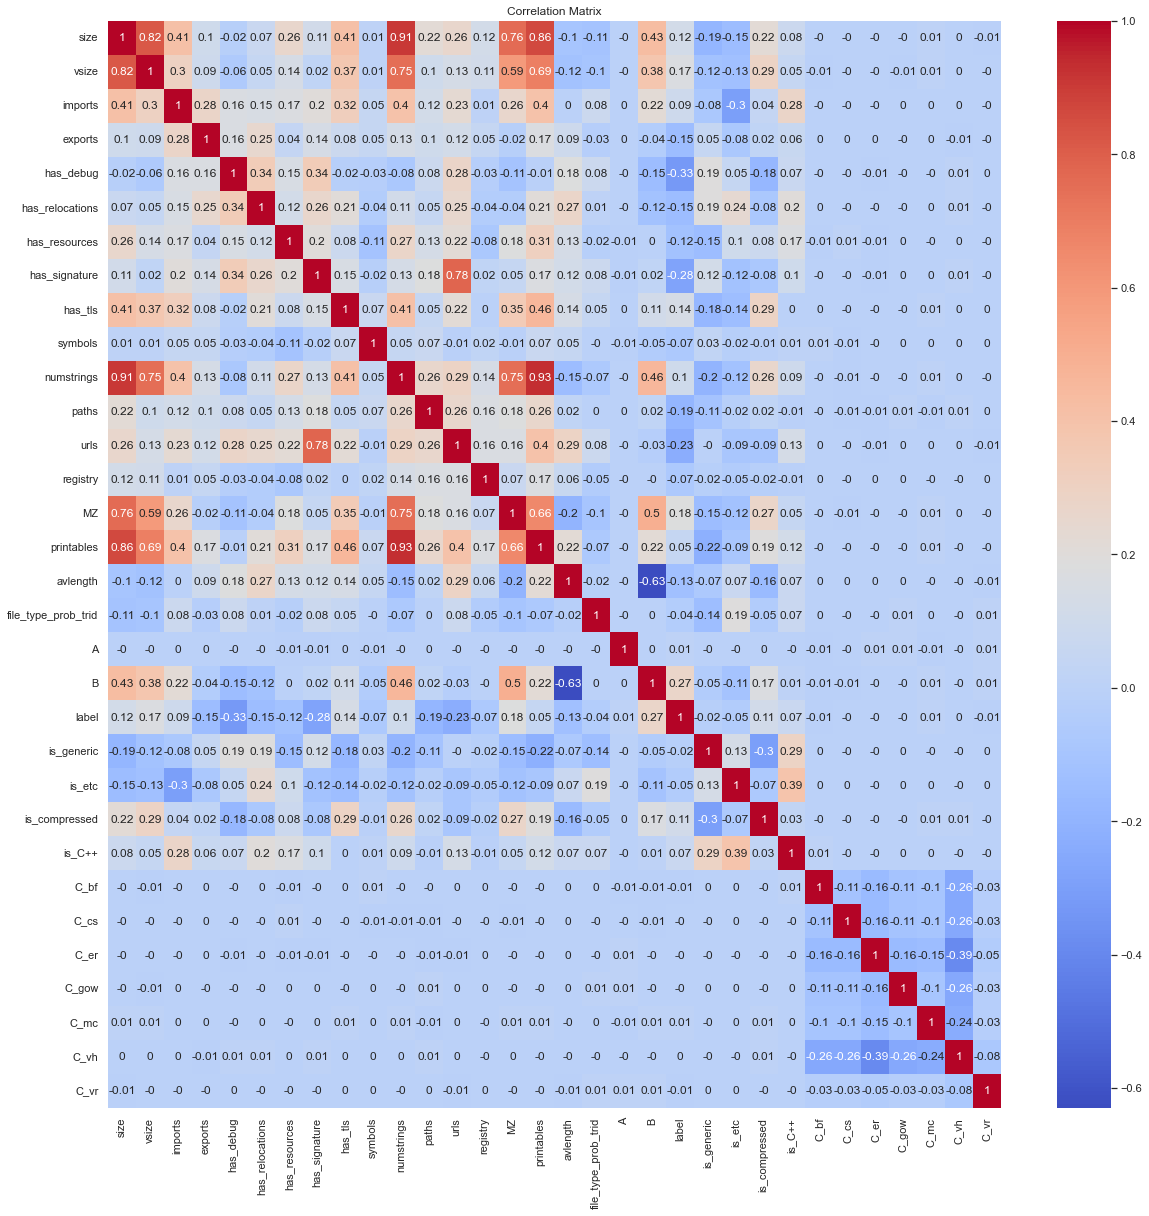

In [91]:
### lets define the train_df -> adding the log to some of the features

#we are andding log to: ['size', 'vsize','numstrings','printables', 'MZ', 'urls', 'paths', 'avlength' ,'symbols', 'exports', 'imports', 'registry']
for feature in to_log:
    train_df[feature] = np.log10(train_df[feature]+1) # so 0 features will be ok
    
train_df.head()

train_df['C'].fillna("unknown", inplace=True)


# and turn C into a catagorial feature

C_val = cat_df["C"].unique()
print(C_val)
C_val[-1] = 'unknown'


#this will make the same adjustments to the test df, if something is not in the original c values its None
c_test.loc[~testing_df['C'].isin(C_val), 'C'] = None
c_test['C'].fillna("unknown", inplace=True)

#
enc = OneHotEncoder()
enc.fit(train_df[['C']])
#

dummy_variables = enc.transform(train_df[['C']]).toarray()
dummy_df = pd.DataFrame(dummy_variables, columns=enc.get_feature_names_out(['C']))
train_df = pd.concat([train_df, dummy_df], axis=1)
train_df.drop(["C", 'C_unknown'],axis=1, inplace=True)

dummy_variables = enc.transform(c_test[['C']]).toarray()
dummy_df = pd.DataFrame(dummy_variables, columns=enc.get_feature_names_out(['C']))
c_test = pd.concat([c_test, dummy_df], axis=1)
c_test.drop(["C", 'C_unknown'],axis=1, inplace=True)

for col in numerical:
    train_df[col].plot.density()
    plt.title(col+" density")
    plt.show()
corr_matrix = train_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

In [92]:
#we will remove sha256 and file_type_trid because they no meaning:
removed_features = ['sha256', 'file_type_trid']
train_df.drop(removed_features, axis=1, inplace=True)
c_test.drop(removed_features, axis=1, inplace=True)

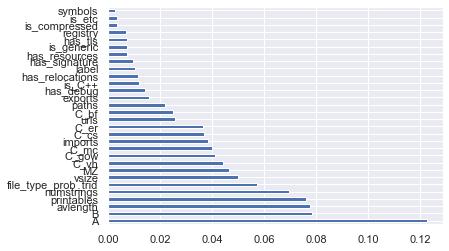

<Figure size 2160x2160 with 0 Axes>

In [93]:
#top important features in data without NaN observations 
try_train_df = train_df.copy()
try_train_df = try_train_df.dropna() #just for the model

X = try_train_df.iloc[:,1:train_df.shape[1]-1]  #independent columns
y = try_train_df.iloc[:,-1]    #target column i.e price range
model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(train_df.shape[1]-1).plot(kind='barh')
plt.figure(figsize=(30, 30))
plt.show()

features to remove:

features with low variance:
1. symbols
2. registry
3. exports

features that are corr with others:

1. size
2. vsize
3. numstrings


In [94]:
removed_features = ['symbols', 'registry', 'exports', 'size', 'vsize', 'numstrings']
train_df.drop(removed_features, axis=1, inplace=True)
c_test.drop(removed_features, axis=1, inplace=True)

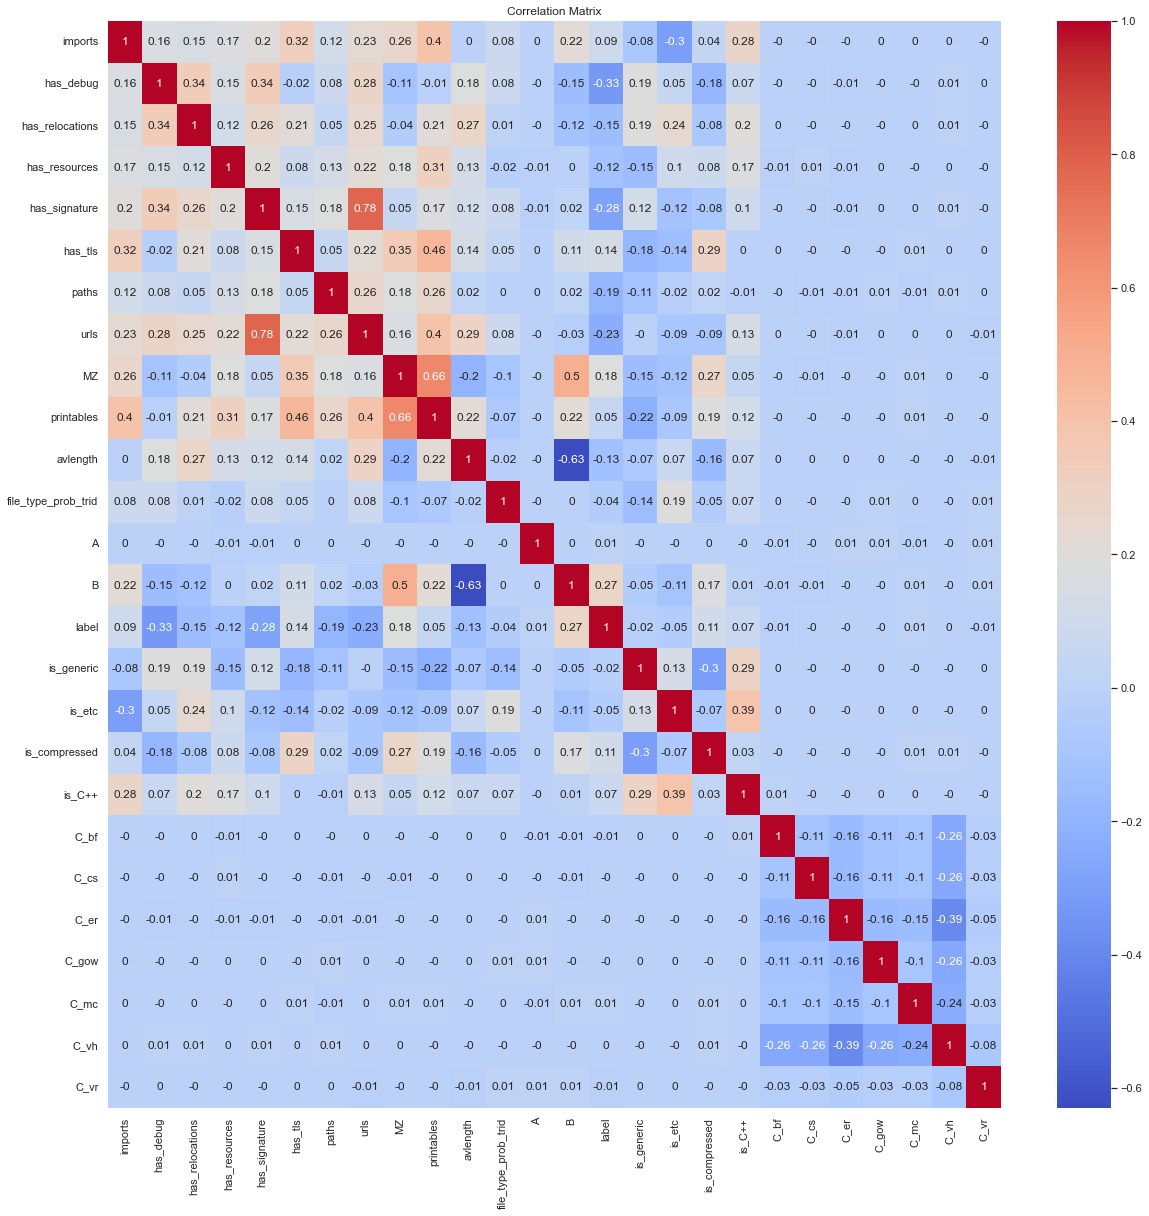

In [95]:
corr_matrix = train_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

In [96]:
features = train_df.columns.tolist()
print("The features in our final DB are: ", features)

The features in our final DB are:  ['imports', 'has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'paths', 'urls', 'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B', 'label', 'is_generic', 'is_etc', 'is_compressed', 'is_C++', 'C_bf', 'C_cs', 'C_er', 'C_gow', 'C_mc', 'C_vh', 'C_vr']


Step 2: removing outliers

if feature is normally distributed then we will use boxplot

else: we will use isolation forest

for feature A to remove 1 stds detected 17645 outliers
for feature A to remove 2 stds detected 2900 outliers
for feature A to remove 3 stds detected 453 outliers
for eps = 0.1 removed  58875
for eps = 0.5 removed  56071
for eps = 1 removed  52996
for eps = 1.5 removed  42002
for eps = 2 removed  28208
for eps = 2.5 removed  17362
for eps = 3 removed  10595
for eps = 3.5 removed  7067
for eps = 4 removed  5353
for eps = 4.5 removed  4376
for min_samples = 2 removed  51032
for min_samples = 3 removed  53950
for min_samples = 4 removed  55198
for max_samples = 50 removed  5872
for max_samples = 100 removed  5176
for max_samples = 150 removed  4889
for max_samples = 200 removed  4711
for max_samples = 250 removed  4547
for max_samples = 300 removed  4390
for max_samples = 350 removed  4904
for max_samples = 400 removed  4574
for max_samples = 450 removed  4160


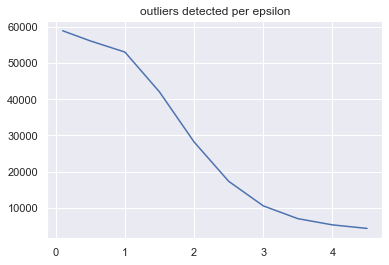

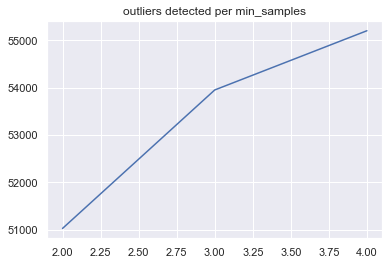

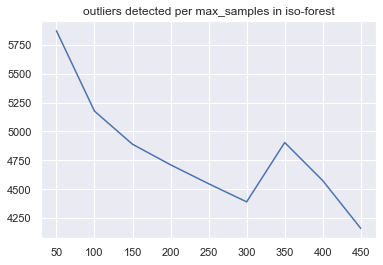

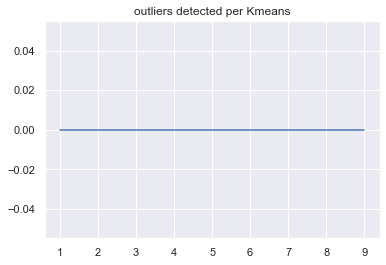

In [97]:
# step 1: using boxplot

normal_features = normal_log+['A']
no_outliers = train_df.copy()
for norm in normal_features:
    for i in range (1,4):
        if (norm in removed_features):
            continue
        removed = train_df[(np.abs(stats.zscore(train_df[norm].fillna(train_df[norm].mean())))>=i)].shape[0]
        print("for feature",norm,'to remove', i,'stds detected',removed,'outliers')
   
   
# step 2: isolation forest
### removing outliers with isolation forest
normal_features = normal_log+['A']
no_outliers.fillna(-999,inplace=True) #we will turn it back to -1
total = train_df.shape[0] # get num of rows
outlier_clf = IsolationForest(max_samples=100, random_state = 1, contamination= 'auto')

epsilons = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
outliers = []
for ep in epsilons:
    pred = DBSCAN(eps=ep).fit_predict(no_outliers)
    outliers.append(len(pred[pred==-1]))
    print('for eps =',ep, 'removed ',len(pred[pred==-1]))

samples_outliers = []
min_samples = list(range(2, 5))
for min in min_samples:
    pred = DBSCAN(min_samples=min).fit_predict(no_outliers)
    samples_outliers.append(len(pred[pred==-1]))
    print('for min_samples =',min, 'removed ',len(pred[pred==-1]))

iso_samples = list(range(50, 500, 50))
iso_outliers = []
for max_samp in iso_samples:
    pred = IsolationForest(max_samples=max_samp).fit_predict(no_outliers)
    iso_outliers.append(len(pred[pred==-1]))
    print('for max_samples =',max_samp, 'removed ',len(pred[pred==-1]))


Ks = list(range(1, 10))
k_outliers=[]

for k in Ks:
    pred = KMeans(n_clusters=k).fit_predict(no_outliers)
    k_outliers.append(len(pred[pred==-1]))
plt.plot(epsilons, outliers)
plt.title("outliers detected per epsilon")
plt.show()

plt.plot(min_samples, samples_outliers)
plt.title("outliers detected per min_samples")
plt.show()


plt.plot(iso_samples, iso_outliers)
plt.title("outliers detected per max_samples in iso-forest")
plt.show()


plt.plot(Ks, k_outliers)
plt.title("outliers detected per Kmeans")
plt.show()

no_outliers.replace(-999, np.nan, inplace=True)

In [98]:
train_df = no_outliers.copy() #### we do copy just so we can re-run this cell
for norm in normal_log+['A']: ### outlier removal via boxplot
    if (norm in removed_features):
        continue
    train_df = train_df[(np.abs(stats.zscore(train_df[norm], nan_policy='omit'))<3)]
    print("for feature",norm,'to remove', i,'stds detected',removed,'outliers')

train_df = train_df[DBSCAN(eps=2.5).fit_predict(train_df.fillna(-999))!=-1] ### outlier removal via dbscan

for feature A to remove 3 stds detected 453 outliers


In [99]:
train_df.isnull().mean()*100

imports                0.992044
has_debug              2.232720
has_relocations        2.553456
has_resources          1.238190
has_signature          1.163600
has_tls                2.048732
paths                  3.003481
urls                   1.596221
MZ                     2.386872
printables             2.158130
avlength               1.994033
file_type_prob_trid    0.000000
A                      0.000000
B                      3.483342
label                  0.000000
is_generic             0.000000
is_etc                 0.000000
is_compressed          0.000000
is_C++                 0.000000
C_bf                   0.000000
C_cs                   0.000000
C_er                   0.000000
C_gow                  0.000000
C_mc                   0.000000
C_vh                   0.000000
C_vr                   0.000000
dtype: float64

In [100]:
c_test.isnull().mean()*100

imports                7.077778
has_debug              8.966667
has_relocations        5.527778
has_resources          3.488889
has_signature          3.083333
has_tls                4.922222
paths                  6.388889
urls                   4.194444
MZ                     4.922222
printables             4.677778
avlength               4.405556
file_type_prob_trid    0.000000
A                      6.516667
B                      6.322222
is_generic             0.000000
is_etc                 0.000000
is_compressed          0.000000
is_C++                 0.000000
C_bf                   0.000000
C_cs                   0.000000
C_er                   0.000000
C_gow                  0.000000
C_mc                   0.000000
C_vh                   0.000000
C_vr                   0.000000
dtype: float64

after we dealt with outliers, we can now deal with missing values

In [101]:
#dealing with missing values in categorial features

boolean_features = [cat for cat in features if 'has' in cat]

#TO-CHECK
for feature in boolean_features:
    mode_value = train_df[feature].mode()[0]
    train_df[feature].fillna(mode_value, inplace=True)  # Fill NaN with mode (the most frequently occurring value)
    c_test[feature].fillna(mode_value, inplace=True)
    

In [102]:
#dealing with missing values in numeric features
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for numeric in numerical:
    if numeric in removed_features:
        continue
    # Fill NaN values with the mean
    #TO-CHECK
    train_df[numeric] = imputer.fit_transform(train_df[[numeric]])
    c_test[numeric] = imputer.transform(c_test[[numeric]])
    
#from now on we will work with test_df
test_df = c_test.copy()

In [103]:
train_df.isnull().mean()*100

imports                0.0
has_debug              0.0
has_relocations        0.0
has_resources          0.0
has_signature          0.0
has_tls                0.0
paths                  0.0
urls                   0.0
MZ                     0.0
printables             0.0
avlength               0.0
file_type_prob_trid    0.0
A                      0.0
B                      0.0
label                  0.0
is_generic             0.0
is_etc                 0.0
is_compressed          0.0
is_C++                 0.0
C_bf                   0.0
C_cs                   0.0
C_er                   0.0
C_gow                  0.0
C_mc                   0.0
C_vh                   0.0
C_vr                   0.0
dtype: float64

In [104]:
c_test.isnull().mean()*100

imports                0.0
has_debug              0.0
has_relocations        0.0
has_resources          0.0
has_signature          0.0
has_tls                0.0
paths                  0.0
urls                   0.0
MZ                     0.0
printables             0.0
avlength               0.0
file_type_prob_trid    0.0
A                      0.0
B                      0.0
is_generic             0.0
is_etc                 0.0
is_compressed          0.0
is_C++                 0.0
C_bf                   0.0
C_cs                   0.0
C_er                   0.0
C_gow                  0.0
C_mc                   0.0
C_vh                   0.0
C_vr                   0.0
dtype: float64

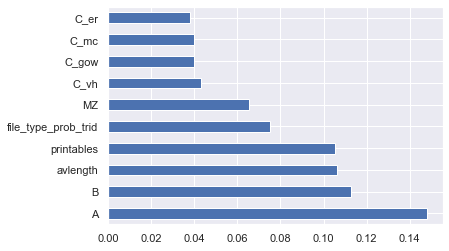

In [105]:
#top 10 most important features in data

X = train_df.iloc[:,1:train_df.shape[1]-1]  #independent columns
y = train_df.iloc[:,-1]    #target column i.e price range
model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [106]:
# normalizing the data

#log_removed_features = ['sha256','file_type_trid', 'avlength']
#log_removed_features = ['sha256','size', 'vsize', 'avlength', 'numstrings', 'file_type_prob_trid', 'file_type_trid']
#st_removed_featuers  = ['sha256','size', 'vsize', 'numstrings', 'file_type_prob_trid','file_type_trid']
X_train = train_df.copy()
X_train.drop('label', axis=1, inplace=True)
X_train.describe()
y_train = train_df['label']

X_test = test_df.copy()
sc = StandardScaler()

for col in X_test.columns:
    X_train[col] = sc.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = sc.transform(X_test[col].values.reshape(-1, 1))
    
X_train.describe()

#log_test.drop(log_removed_features, axis=1, inplace=True)

,imports,has_debug,has_relocations,has_resources,has_signature,has_tls,paths,urls,MZ,printables,avlength,file_type_prob_trid,A,B,is_generic,is_etc,is_compressed,is_C++,C_bf,C_cs,C_er,C_gow,C_mc,C_vh,C_vr
count,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04,4.022000e+04
mean,-1.091784e-16,-1.310847e-16,4.116272e-17,-1.279931e-16,-3.391949e-17,-8.303209e-18,-7.066561e-19,-2.755959e-17,1.236648e-16,-2.070502e-16,7.278558e-17,-3.469682e-16,-2.782459e-17,2.630527e-16,-1.095317e-16,1.678308e-18,9.875519e-17,6.642568e-17,-5.582583e-17,1.483978e-17,5.679749e-17,1.837306e-17,2.314299e-17,-3.533281e-19,7.313891e-17
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.493341e+00,-8.083582e-01,-1.095545e+00,-2.416878e+00,-5.630315e-01,-5.328391e-01,-4.830919e-01,-6.960706e-01,-1.065419e+00,-3.789992e+00,-1.202453e+00,-1.553259e+00,-3.140116e+00,-6.444934e+00,-2.115969e+00,-2.509035e-01,-2.470177e-01,-6.742876e-01,-3.260564e-01,-3.297766e-01,-4.856987e-01,-3.162105e-01,-3.046572e-01,-8.088207e-01,-9.740367e-02
25%,-1.160209e+00,-8.083582e-01,-1.095545e+00,4.137569e-01,-5.630315e-01,-5.328391e-01,-4.830919e-01,-6.960706e-01,-1.065419e+00,-5.858891e-01,-7.226258e-01,-7.134063e-01,-6.959259e-01,-5.533718e-01,4.725967e-01,-2.509035e-01,-2.470177e-01,-6.742876e-01,-3.260564e-01,-3.297766e-01,-4.856987e-01,-3.162105e-01,-3.046572e-01,-8.088207e-01,-9.740367e-02
50%,1.081425e-01,-8.083582e-01,9.127877e-01,4.137569e-01,-5.630315e-01,-5.328391e-01,-4.830919e-01,-6.960706e-01,-1.881680e-01,8.507587e-02,-1.087452e-01,-5.058566e-01,-3.806585e-02,8.174924e-02,4.725967e-01,-2.509035e-01,-2.470177e-01,-6.742876e-01,-3.260564e-01,-3.297766e-01,-4.856987e-01,-3.162105e-01,-3.046572e-01,-8.088207e-01,-9.740367e-02
75%,9.083581e-01,1.237075e+00,9.127877e-01,4.137569e-01,-5.630315e-01,-5.328391e-01,-4.830919e-01,9.009545e-01,6.500000e-01,6.321780e-01,3.941174e-01,6.863475e-01,6.457577e-01,8.476246e-01,4.725967e-01,-2.509035e-01,-2.470177e-01,1.483047e+00,-3.260564e-01,-3.297766e-01,-4.856987e-01,-3.162105e-01,-3.046572e-01,1.236368e+00,-9.740367e-02
max,2.616529e+00,1.237075e+00,9.127877e-01,4.137569e-01,1.776100e+00,1.876739e+00,1.041488e+01,5.042674e+00,6.265839e+00,3.467741e+00,9.474936e+00,2.259864e+00,3.496382e+00,1.269341e+00,4.725967e-01,3.985595e+00,4.048293e+00,1.483047e+00,3.066954e+00,3.032356e+00,2.058889e+00,3.162451e+00,3.282378e+00,1.236368e+00,1.026655e+01


In [107]:
### define a functino that will perform a grid search on model

def getBestModel(estimator, params, XTrain, ytrain, XTest, ytest, v=3):
    cv = GridSearchCV(estimator= estimator, param_grid=params, verbose=v, scoring='roc_auc')
    cv.fit(XTrain, ytrain)
    print("Best Parameters:",  cv.best_params_)
    pred = cv.predict_proba(XTest)[:,1]
    val_auc = metrics.roc_auc_score(ytest, pred)
    print('validation AUC:',val_auc)
    return cv.best_estimator_

In [108]:
#PCA dimension reduction

Xlog_train, Xlog_val, ylog_train, ylog_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# labels
#lr = LogisticRegression(penalty = 'l2', solver="liblinear")

# we will do PCA in order to further reduce dimensions
for variance in [0.5, 0.6, 0.7, .8, .9, 0.95, 0.99, 0.995, .9999]:
    pca = PCA(variance)
    data = pca.fit_transform(Xlog_train)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])
#log_train = scaler.fit_transform(X_log)
pca = PCA(0.99)

pca.fit(Xlog_train)
X_train_reduced = pca.transform(Xlog_train)
X_val_reduced = pca.transform(Xlog_val)
#X_log_reduced = pca.fit_transform(X_log)
l_test_reduced = pca.transform(X_test)
#X_log_reduced = X_log

powers = range(-10,1)
Cs = [10**p for p in powers] #This is the inverse value for the lambda parameter.



lr = LogisticRegression(solver = 'liblinear', penalty = 'l2')
params = {'C' : Cs,
         'fit_intercept' : [True, False]}
best_model = getBestModel(lr, params, X_train_reduced, ylog_train, X_val_reduced, ylog_val)


For explained variance: 0.5 number of dimensions: 7
For explained variance: 0.6 number of dimensions: 9
For explained variance: 0.7 number of dimensions: 12
For explained variance: 0.8 number of dimensions: 14
For explained variance: 0.9 number of dimensions: 17
For explained variance: 0.95 number of dimensions: 20
For explained variance: 0.99 number of dimensions: 23
For explained variance: 0.995 number of dimensions: 24
For explained variance: 0.9999 number of dimensions: 25
Fitting 5 folds for each of 22 candidates, totalling 110 fits
[CV 1/5] END .......C=1e-10, fit_intercept=True;, score=0.783 total time=   0.0s
[CV 2/5] END .......C=1e-10, fit_intercept=True;, score=0.781 total time=   0.0s
[CV 3/5] END .......C=1e-10, fit_intercept=True;, score=0.777 total time=   0.0s
[CV 4/5] END .......C=1e-10, fit_intercept=True;, score=0.778 total time=   0.0s
[CV 5/5] END .......C=1e-10, fit_intercept=True;, score=0.784 total time=   0.0s
[CV 1/5] END ......C=1e-10, fit_intercept=False;, s

In [109]:
gbm_clf = ensemble.RandomForestClassifier(random_state=0, n_estimators=100)
params = {'criterion' : ['gini', 'entropy', 'log_loss']}
best_model = getBestModel(gbm_clf, params, Xlog_train, ylog_train, Xlog_val, ylog_val)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ....................criterion=gini;, score=0.976 total time=   4.6s
[CV 2/5] END ....................criterion=gini;, score=0.976 total time=   4.2s
[CV 3/5] END ....................criterion=gini;, score=0.976 total time=   4.1s
[CV 4/5] END ....................criterion=gini;, score=0.978 total time=   4.1s


KeyboardInterrupt: 

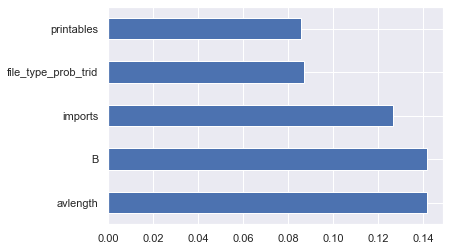

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=Xlog_train.columns)
feat_importances.nlargest().plot(kind='barh')
plt.show()

In [ ]:
best_model_pca = getBestModel(r_clf, params, X_train_reduced, ylog_train, X_val_reduced ,ylog_val)  

In [ ]:
mlp_clf = MLPClassifier(solver='sgd')
params = {'activation' : ['logistic', 'relu'],
          'alpha' : [0.0001, 0.001, 0.01, .1, 1],
          'learning_rate_init' : [0.001, 0.01, 0.1]}

mlp_cv = GridSearchCV(mlp_clf, param_grid=params, verbose=3, scoring = 'roc_auc', cv=3)
mlp_cv.fit(X_train_reduced, ylog_train)

pred = mlp_cv.predict_proba(X_val_reduced)[:,1]

val_auc = metrics.roc_auc_score(ylog_val, pred)
print("Validation set auc for the log df:",val_auc)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV 1/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.001;, score=0.824 total time=   9.3s
[CV 2/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.001;, score=0.807 total time=   8.0s
[CV 3/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.001;, score=0.815 total time=   9.0s
[CV 1/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.01;, score=0.939 total time=  15.8s
[CV 2/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.01;, score=0.938 total time=  15.7s
[CV 3/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.01;, score=0.940 total time=  17.7s
[CV 1/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.1;, score=0.949 total time=  16.0s
[CV 2/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.1;, score=0.944 total time=  15.8s
[CV 3/3] END activation=logistic, alpha=0.0001, learning_rate_init=0.1;, score=0.946 total time=  

In [ ]:
model = KNeighborsClassifier()
kparams = {'n_neighbors': range(1, 100, 10)}
kcv = GridSearchCV(model, param_grid=kparams, scoring = 'roc_auc', verbose=3)
kcv.fit(X_train_reduced, ylog_train)

best_clf = kcv.best_estimator_
pred = best_clf.predict_proba(X_val_reduced)[:,1]

val_auc = metrics.roc_auc_score(ylog_val, pred)
print("Validation set auc for the log df:",val_auc)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.847 total time=   0.2s
[CV 2/5] END .....................n_neighbors=1;, score=0.843 total time=   0.2s
[CV 3/5] END .....................n_neighbors=1;, score=0.852 total time=   0.2s
[CV 4/5] END .....................n_neighbors=1;, score=0.846 total time=   0.2s
[CV 5/5] END .....................n_neighbors=1;, score=0.848 total time=   0.2s
[CV 1/5] END ....................n_neighbors=11;, score=0.931 total time=   0.3s
[CV 2/5] END ....................n_neighbors=11;, score=0.926 total time=   0.2s
[CV 3/5] END ....................n_neighbors=11;, score=0.930 total time=   0.2s
[CV 4/5] END ....................n_neighbors=11;, score=0.927 total time=   0.2s
[CV 5/5] END ....................n_neighbors=11;, score=0.931 total time=   0.2s
[CV 1/5] END ....................n_neighbors=21;, score=0.929 total time=   0.3s
[CV 2/5] END ....................n_neighbors=21;